In [1]:
import os 
import pandas as pd
from datetime import datetime, timedelta

# 📁 Dossier principal contenant les expériences
root_dir = "."

# 📌 Liste des classes valides
valid_classes = ["CPU HOG", "MEM LEAK", "Packet Loss", "Packet Delay"]

# 📌 Liste pour stocker les DataFrames de chaque fichier
df_list = []

# 🔍 Parcours des sous-dossiers (microservices)
for microservice in os.listdir(root_dir):
    microservice_path = os.path.join(root_dir, microservice)
    
    if os.path.isdir(microservice_path):  # Vérifier si c'est un dossier
        # Déterminer la classe en fonction du suffixe (_cpu, _mem, _loss, _delay)
        if microservice.endswith("_cpu"):
            failure_class = "CPU HOG"
        elif microservice.endswith("_mem"):
            failure_class = "MEM LEAK"
        elif microservice.endswith("_loss"):
            failure_class = "Packet Loss"
        elif microservice.endswith("_delay"):
            failure_class = "Packet Delay"
        else:
            failure_class = "Normal"  # Si aucun suffixe spécifique n'est trouvé
        
        # 🔍 Parcours des expériences (1,2,3,4,5)
        for experiment in os.listdir(microservice_path):
            experiment_path = os.path.join(microservice_path, experiment)
            
            if os.path.isdir(experiment_path): 
                # 📌 Charger le fichier "data.csv" s'il existe
                data_file = os.path.join(experiment_path, "pod_resource_baro.csv")
                
                if os.path.exists(data_file):
                    df = pd.read_csv(data_file)
                    # Convertir la colonne "timestamp" en format datetime avec le format ISO 8601
                    df["timestamp"] = pd.to_datetime(df["timestamp"], format='%Y-%m-%d %H:%M:%S')


                    # Récupérer le timestamp de la première ligne et ajouter 3 minutes (180 secondes)
                    first_timestamp = df["timestamp"].iloc[0]
                    inject_time = first_timestamp + timedelta(minutes=3)
                    
                    # 🏷 Ajouter la classe en fonction de l'injection
                    df["Abnormality class"] = df["timestamp"].apply(
                        lambda x: "Normal" if x < inject_time else failure_class)
                    
                    # 🏷 Ajouter des colonnes pour identifier l'expérience
                    df["Microservice"] = microservice
                    df["Experiment"] = experiment
                    
                    # 📌 Ajouter le DataFrame à la liste
                    df_list.append(df)

# 🏗 Fusionner tous les DataFrames en un seul
df_all = pd.concat(df_list, ignore_index=True)

# 🔎 Affichage de quelques lignes pour vérification
print(df_all.head())

# 📂 Sauvegarde du DataFrame final
df_all.to_csv("final_dataset.csv", index=False)
print("✅ Fichier 'final_dataset.csv' enregistré avec succès !")


ValueError: No objects to concatenate

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3577: DtypeWarning: Columns (33,37,64,68,72,76,80,84,88,92,96,100,104,108,112,116,120,124,128,132,136,140,144,148,152,156,160,164,168,172,176,180,184,188,192,196,200,204,208,212,216,220,224,228,232,236,240,244,248,252,256,260,264) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


📌 Distribution des classes :
 Normal          3420
Packet Delay     912
Packet Loss      911
CPU HOG          906
MEM LEAK         727
Name: Abnormality class, dtype: int64
📌 Colonnes disponibles : Index(['Unnamed: 0', 'timestamp',
       'adservice-5dc4c759b6-rlnh9_container_cpu_usage_seconds_total',
       'adservice-5dc4c759b6-rlnh9_container_memory_working_set_bytes',
       'adservice-5dc4c759b6-rlnh9_container_network_transmit_packets_total',
       'adservice-5dc4c759b6-rlnh9_deployed_at',
       'cartservice-7f84c9f647-jvnlr_container_cpu_usage_seconds_total',
       'cartservice-7f84c9f647-jvnlr_container_memory_working_set_bytes',
       'cartservice-7f84c9f647-jvnlr_container_network_transmit_packets_total',
       'cartservice-7f84c9f647-jvnlr_deployed_at',
       ...
       'loadgenerator-7785849b66-wqs4s_container_network_transmit_packets_total',
       'loadgenerator-7785849b66-wqs4s_deployed_at',
       'loadgenerator-7785849b66-2nvkl_container_cpu_usage_seconds_total',

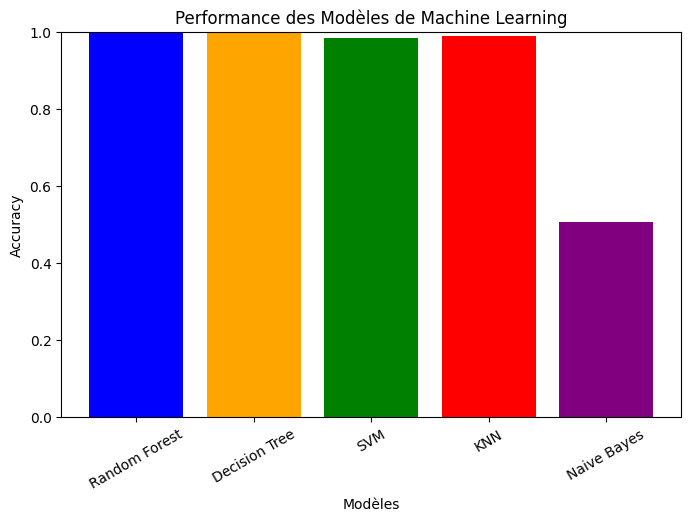

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

# 📂 Charger le dataset
df = pd.read_csv("final_dataset.csv")

# 🔎 Vérifier la distribution des classes
print("📌 Distribution des classes :\n", df["Abnormality class"].value_counts())

# 🎯 Définir X (features) et y (target)
print("📌 Colonnes disponibles :", df.columns)
X = df.drop(columns=["Abnormality class", "Experiment"], errors="ignore")
y = df["Abnormality class"]

# 🎭 Encodage des labels (y)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 🔄 Convert non-numeric columns to numeric
non_numeric_columns = X.select_dtypes(include=['object']).columns
for col in non_numeric_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# 🚨 Handle missing values
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 🎲 Séparer en train & test (80% train, 20% test) avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 🔬 Normalisation des features (important pour SVM et KNN)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ Vérification
print(f"✔️ Taille du jeu de train : {X_train.shape}")
print(f"✔️ Taille du jeu de test : {X_test.shape}")

# 📌 Initialisation des modèles
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# 🔥 Entraînement et évaluation des modèles
accuracies = {}
for name, model in models.items():
    print(f"\n🔹 Entraînement du modèle {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # 🎯 Stocker l'accuracy
    accuracies[name] = accuracy_score(y_test, y_pred)
    
    # 📊 Affichage des résultats
    print(f"📌 Modèle : {name}")
    print(f"🔹 Accuracy : {accuracies[name]:.4f}")
    print(f"🔹 Rapport de classification : \n{classification_report(y_test, y_pred, target_names=label_encoder.classes_)}")
    print("-" * 50)

# 📊 Tracer les résultats
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel("Modèles")
plt.ylabel("Accuracy")
plt.title("Performance des Modèles de Machine Learning")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

In [ ]:
import os 
import pandas as pd
from datetime import datetime, timedelta
import raphtory
# 📁 Dossier principal contenant les expériences
root_dir = "."

# 📌 Liste des classes valides
valid_classes = ["CPU HOG", "MEM LEAK", "Packet Loss", "Packet Delay"]

# 📌 Liste pour stocker les DataFrames de chaque fichier
df_list = []

# 🔍 Parcours des sous-dossiers (microservices)
for microservice in os.listdir(root_dir):
    microservice_path = os.path.join(root_dir, microservice)
    
    if os.path.isdir(microservice_path):  # Vérifier si c'est un dossier
        # Déterminer la classe en fonction du suffixe (_cpu, _mem, _loss, _delay)
        if microservice.endswith("_cpu"):
            failure_class = "CPU HOG"
        elif microservice.endswith("_mem"):
            failure_class = "MEM LEAK"
        elif microservice.endswith("_loss"):
            failure_class = "Packet Loss"
        elif microservice.endswith("_delay"):
            failure_class = "Packet Delay"
        else:
            failure_class = "Normal"  # Si aucun suffixe spécifique n'est trouvé
        
        # 🔍 Parcours des expériences (1,2,3,4,5)
        for experiment in os.listdir(microservice_path):
            experiment_path = os.path.join(microservice_path, experiment)
            
            if os.path.isdir(experiment_path): 
                # 📌 Charger le fichier "data.csv" s'il existe
                data_file = os.path.join(experiment_path, "pod_resource_consumption.csv")
                
                if os.path.exists(data_file):
                    df = pd.read_csv(data_file)
                    # Convertir la colonne "timestamp" en format datetime avec le format ISO 8601
                    df["timestamp"] = pd.to_datetime(df["timestamp"], format='%Y-%m-%d %H:%M:%S')


                    # Récupérer le timestamp de la première ligne et ajouter 3 minutes (180 secondes)
                    first_timestamp = df["timestamp"].iloc[0]
                    inject_time = first_timestamp + timedelta(minutes=3)
                    
                    # 🏷 Ajouter la classe en fonction de l'injection
                    df["Abnormality class"] = df["timestamp"].apply(
                        lambda x: "Normal" if x < inject_time else failure_class)
                    
                    # 🏷 Ajouter des colonnes pour identifier l'expérience
                    df["Microservice"] = microservice
                    df["Experiment"] = experiment
                    
                    # 📌 Ajouter le DataFrame à la liste
                    df_list.append(df)

# 🏗 Fusionner tous les DataFrames en un seul
df_all = pd.concat(df_list, ignore_index=True)

# 🔎 Affichage de quelques lignes pour vérification
print(df_all.head())

# 📂 Sauvegarde du DataFrame final
df_all.to_csv("final2_dataset.csv", index=False)
print("✅ Fichier 'final2_dataset.csv' enregistré avec succès !")


            timestamp                           instance  \
0 2025-04-22 10:30:43  aks-agentpool-42554999-vmss00000x   
1 2025-04-22 10:30:44  aks-agentpool-42554999-vmss00000x   
2 2025-04-22 10:30:45  aks-agentpool-42554999-vmss00000x   
3 2025-04-22 10:30:46  aks-agentpool-42554999-vmss00000x   
4 2025-04-22 10:30:47  aks-agentpool-42554999-vmss00000x   

                              pod  container_cpu_usage_seconds_total  \
0  loadgenerator-7785849b66-zf572                           0.048852   
1  loadgenerator-7785849b66-zf572                           0.051095   
2  loadgenerator-7785849b66-zf572                           0.053337   
3  loadgenerator-7785849b66-zf572                           0.055580   
4  loadgenerator-7785849b66-zf572                           0.057823   

   container_cpu_system_seconds_total  container_memory_working_set_bytes  \
0                            0.005396                        2.418139e+06   
1                            0.005622               

In [ ]:
import pandas as pd

# Charger le fichier CSV
df = pd.read_csv('final2_dataset.csv')

# Parcourir toutes les colonnes qui se terminent par "_deployed_at"
for col in df.columns:
    if col.endswith('instance'):
        # Parcourir toutes les lignes de la colonne et modifier chaque valeur
        for i in range(len(df)):
            current_value = df.at[i, col]  # Récupérer la valeur actuelle de la cellule
            if pd.notna(current_value):  # Vérifier si la cellule n'est pas vide (NaN)
                current_value_str = str(current_value)  # Convertir en chaîne si nécessaire
                # Modifier la valeur en "node" + les deux derniers caractères de la valeur
                df.at[i, col] = 'node' + current_value_str[-2:]

# Trier le DataFrame par la colonne 'timestamp'
df = df.sort_values(by='timestamp')

# Sauvegarder le fichier avec les nouvelles modifications et trié par 'timestamp'
df.to_csv('final2_modified_sorted.csv', index=False)

print("Les colonnes 'instance' ont été modifiées et le fichier a été trié par 'timestamp'. Le fichier a été enregistré sous 'final2_modified_sorted.csv'.")


Les colonnes 'instance' ont été modifiées et le fichier a été trié par 'timestamp'. Le fichier a été enregistré sous 'final2_modified_sorted.csv'.


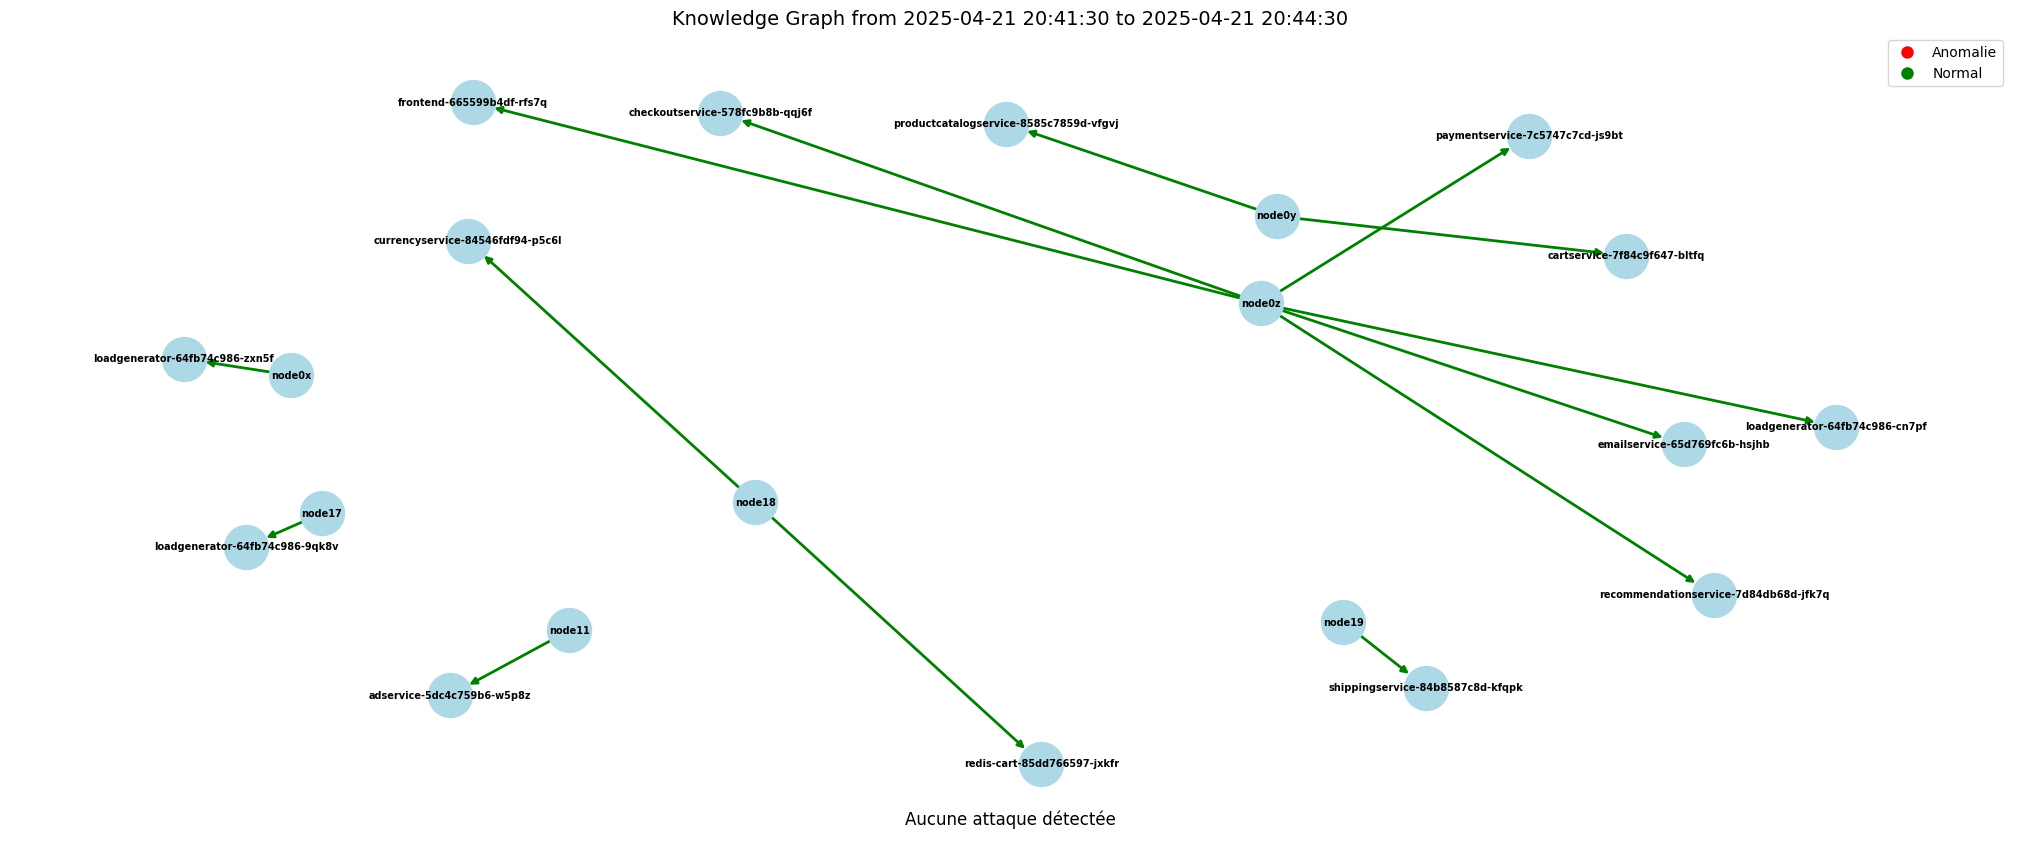

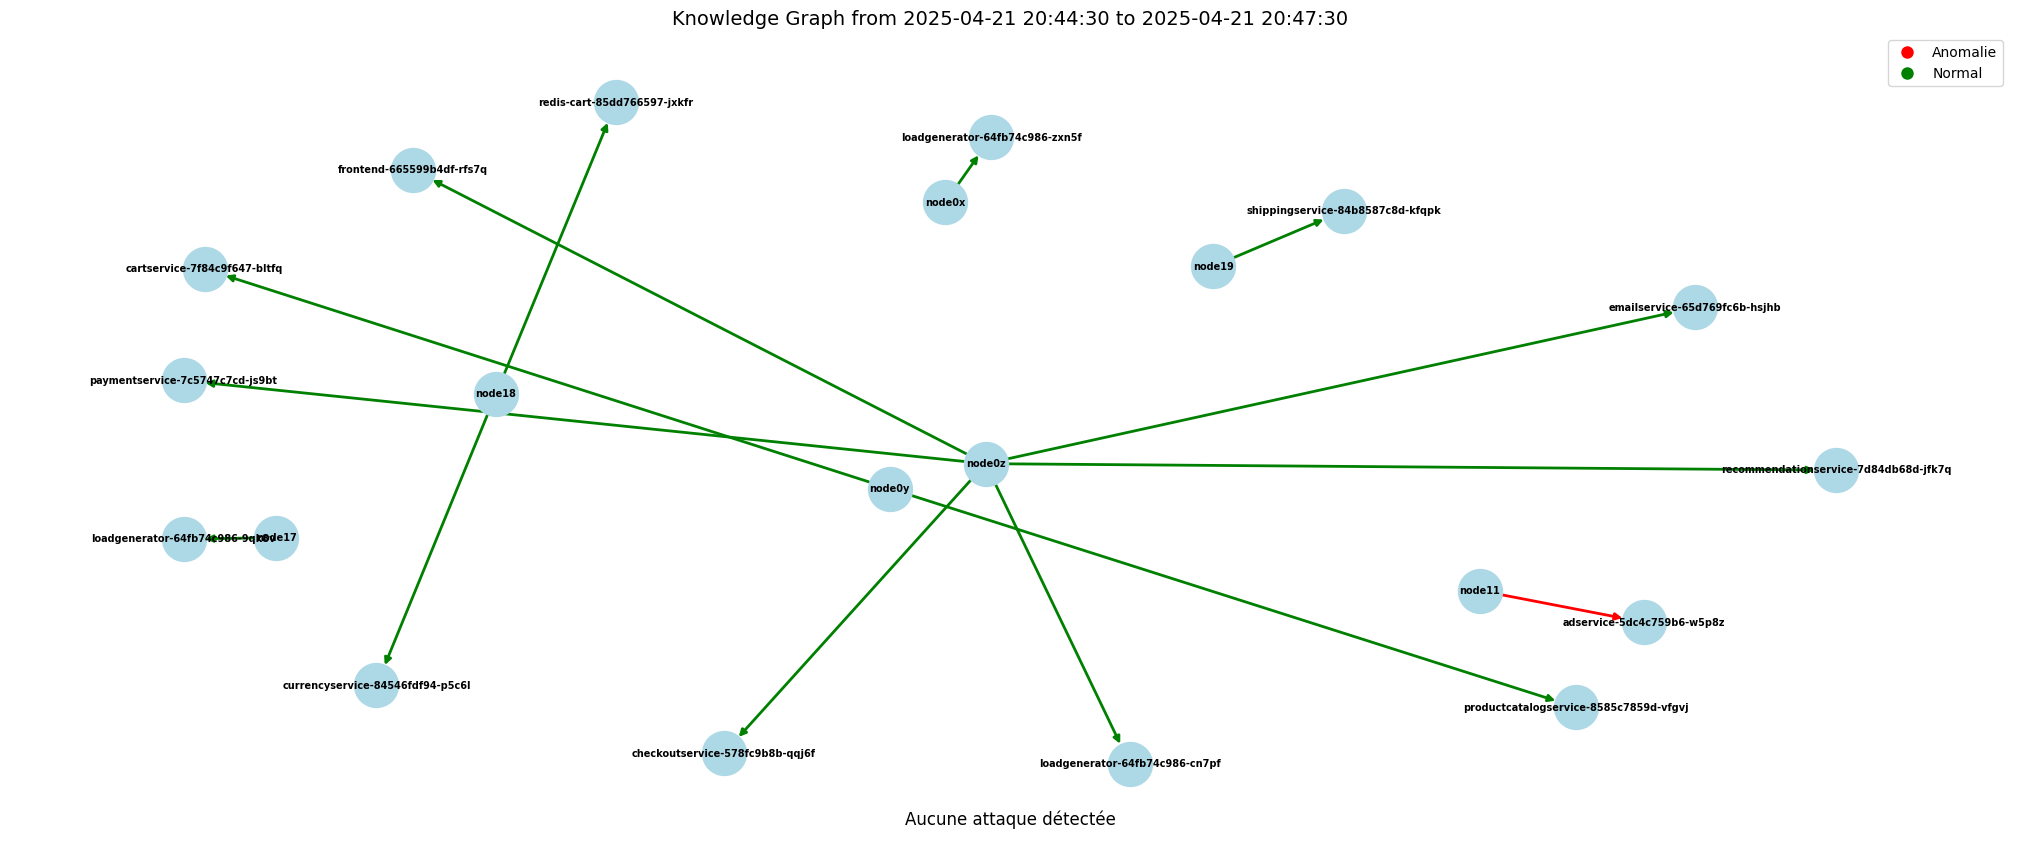

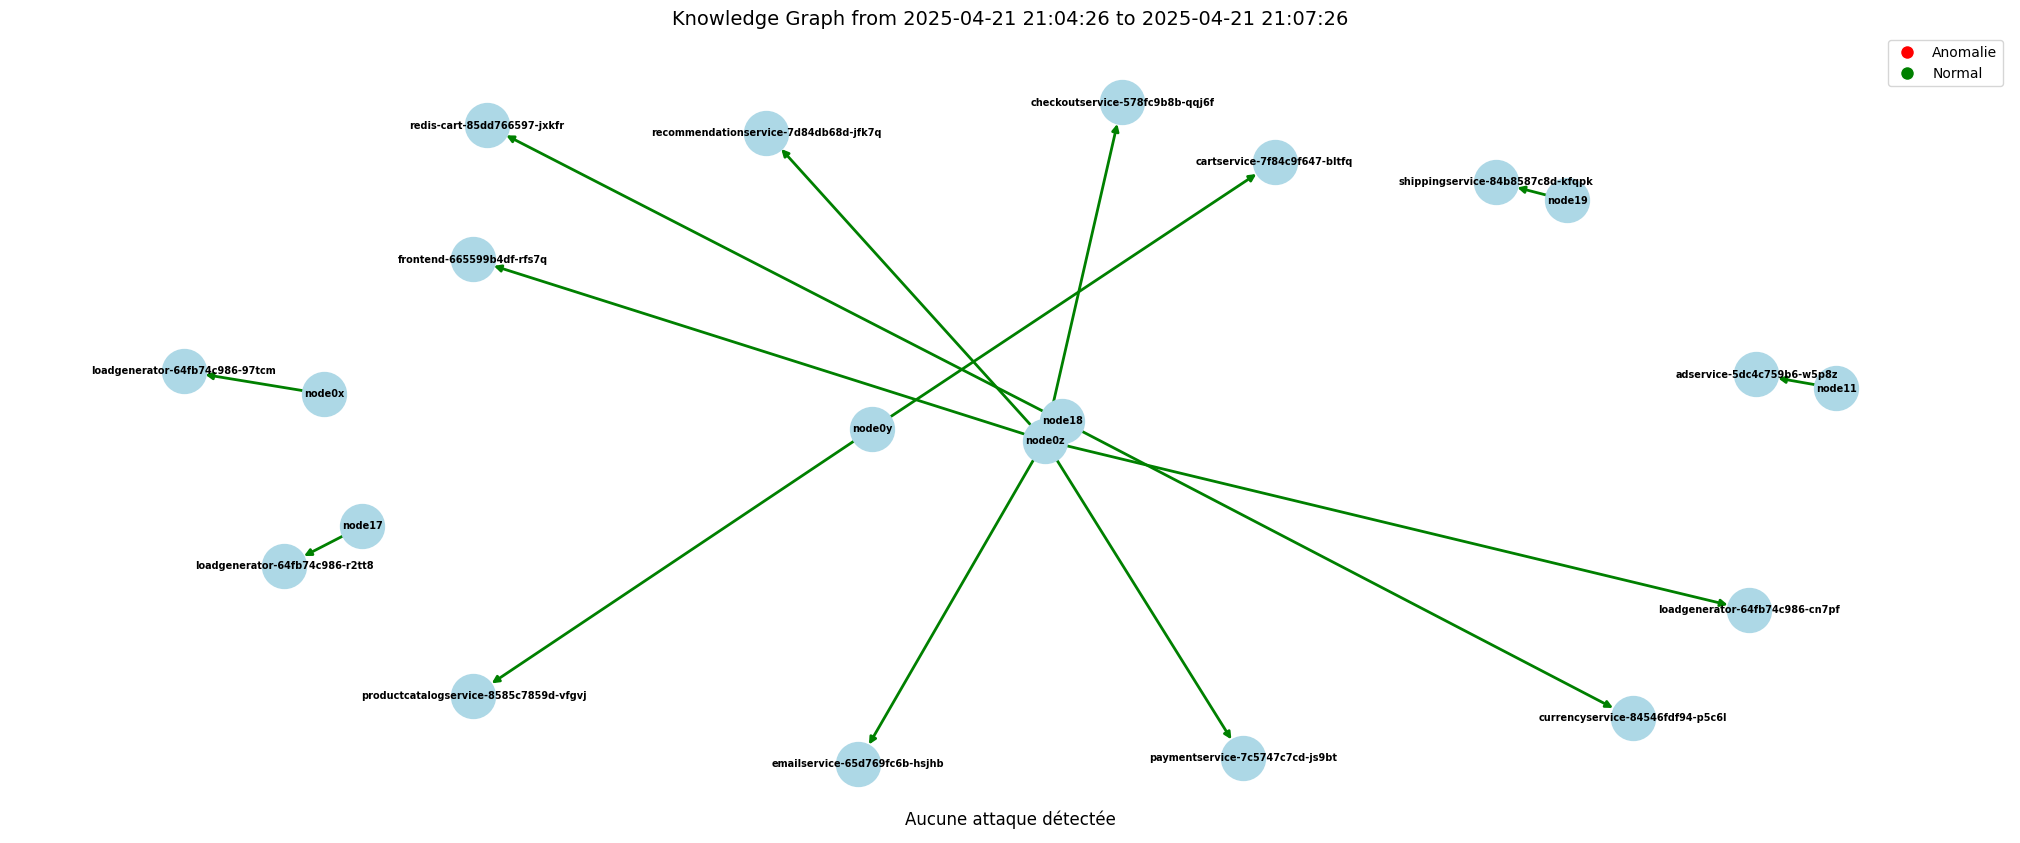

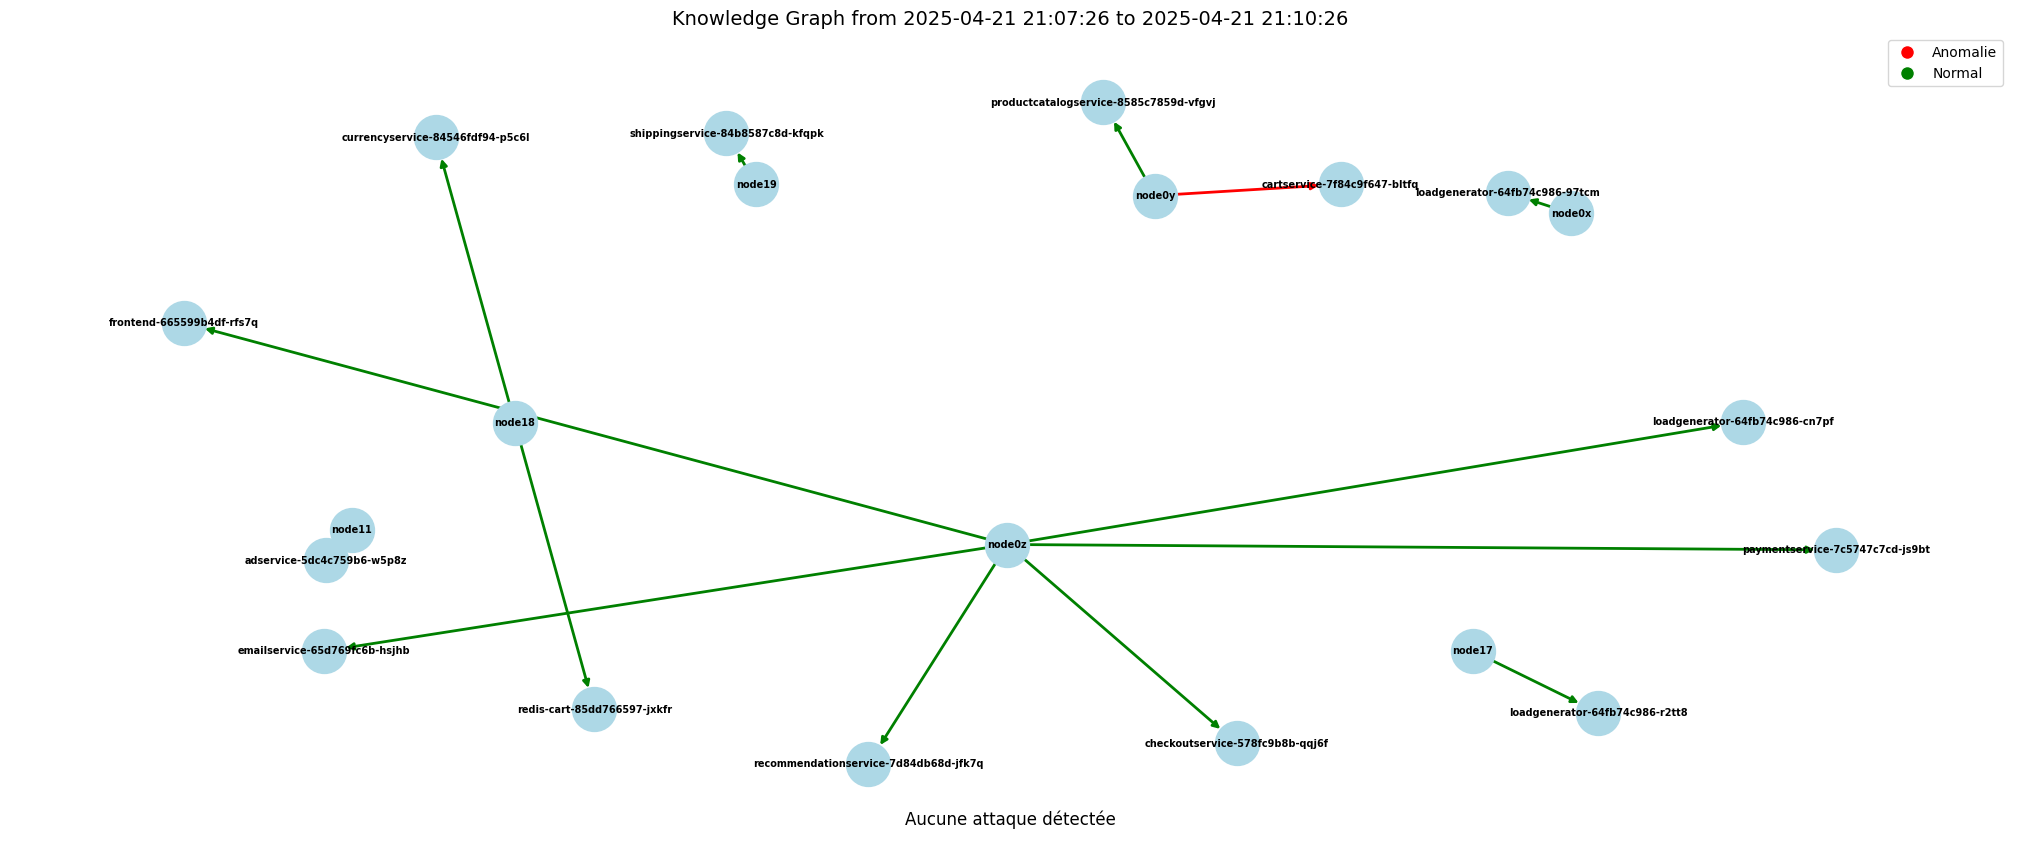

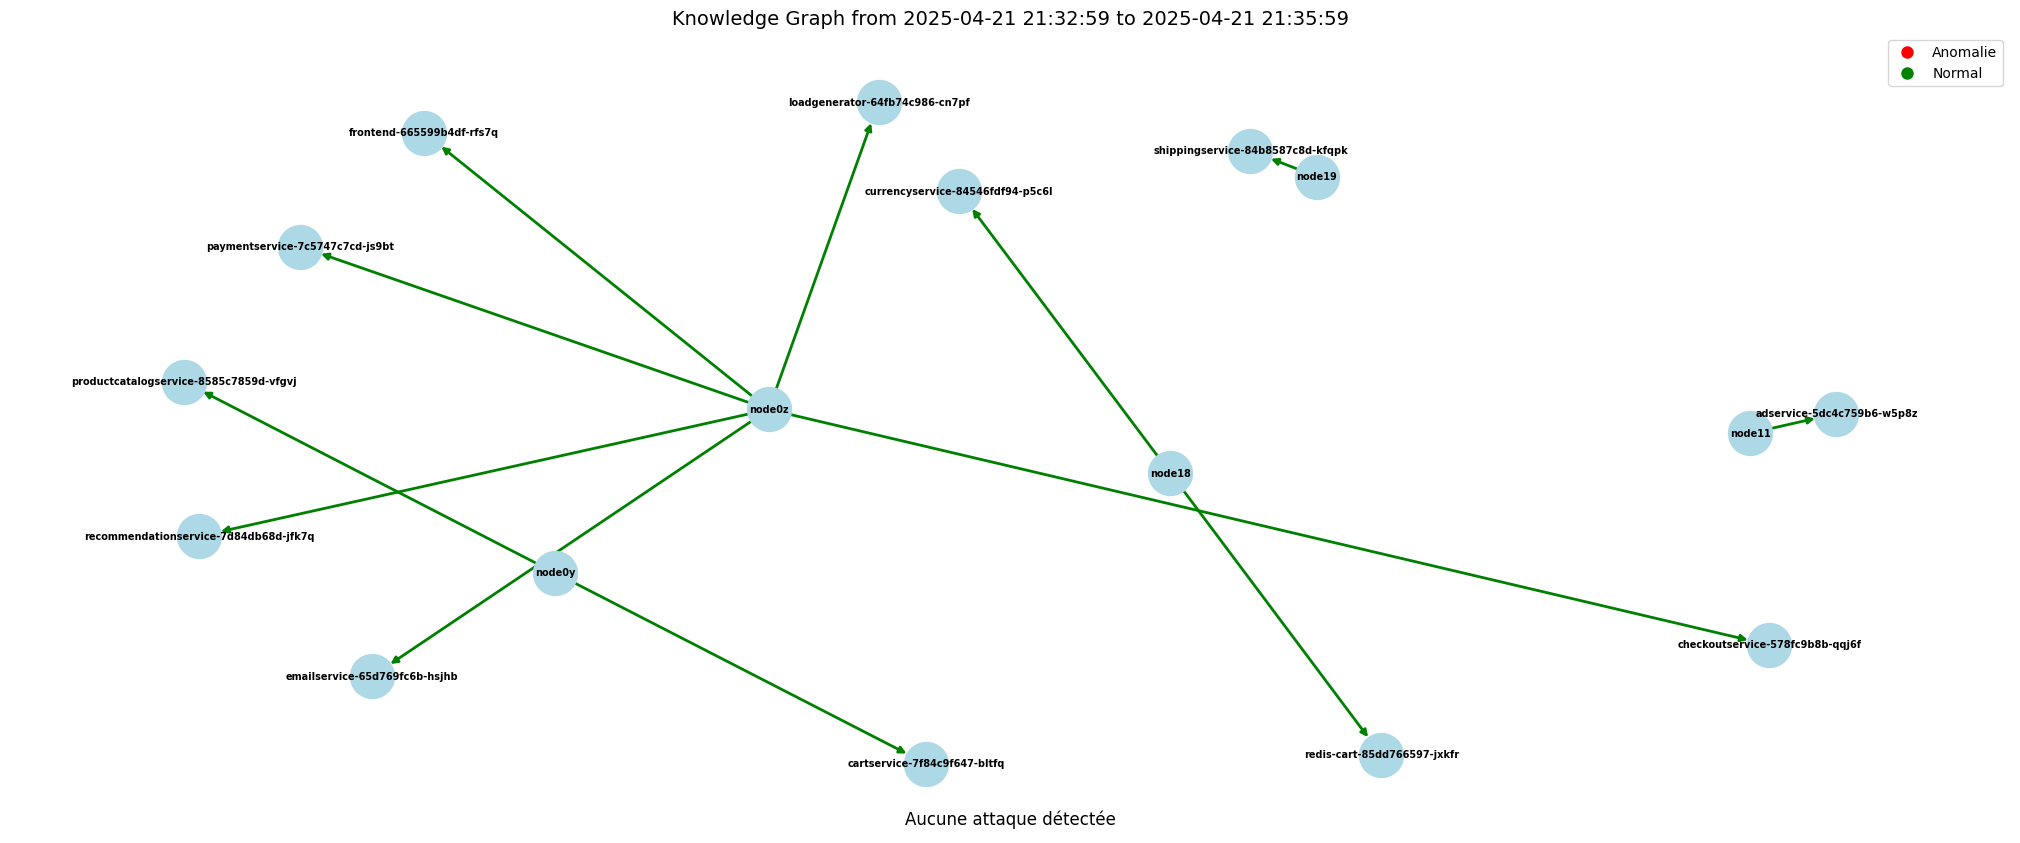

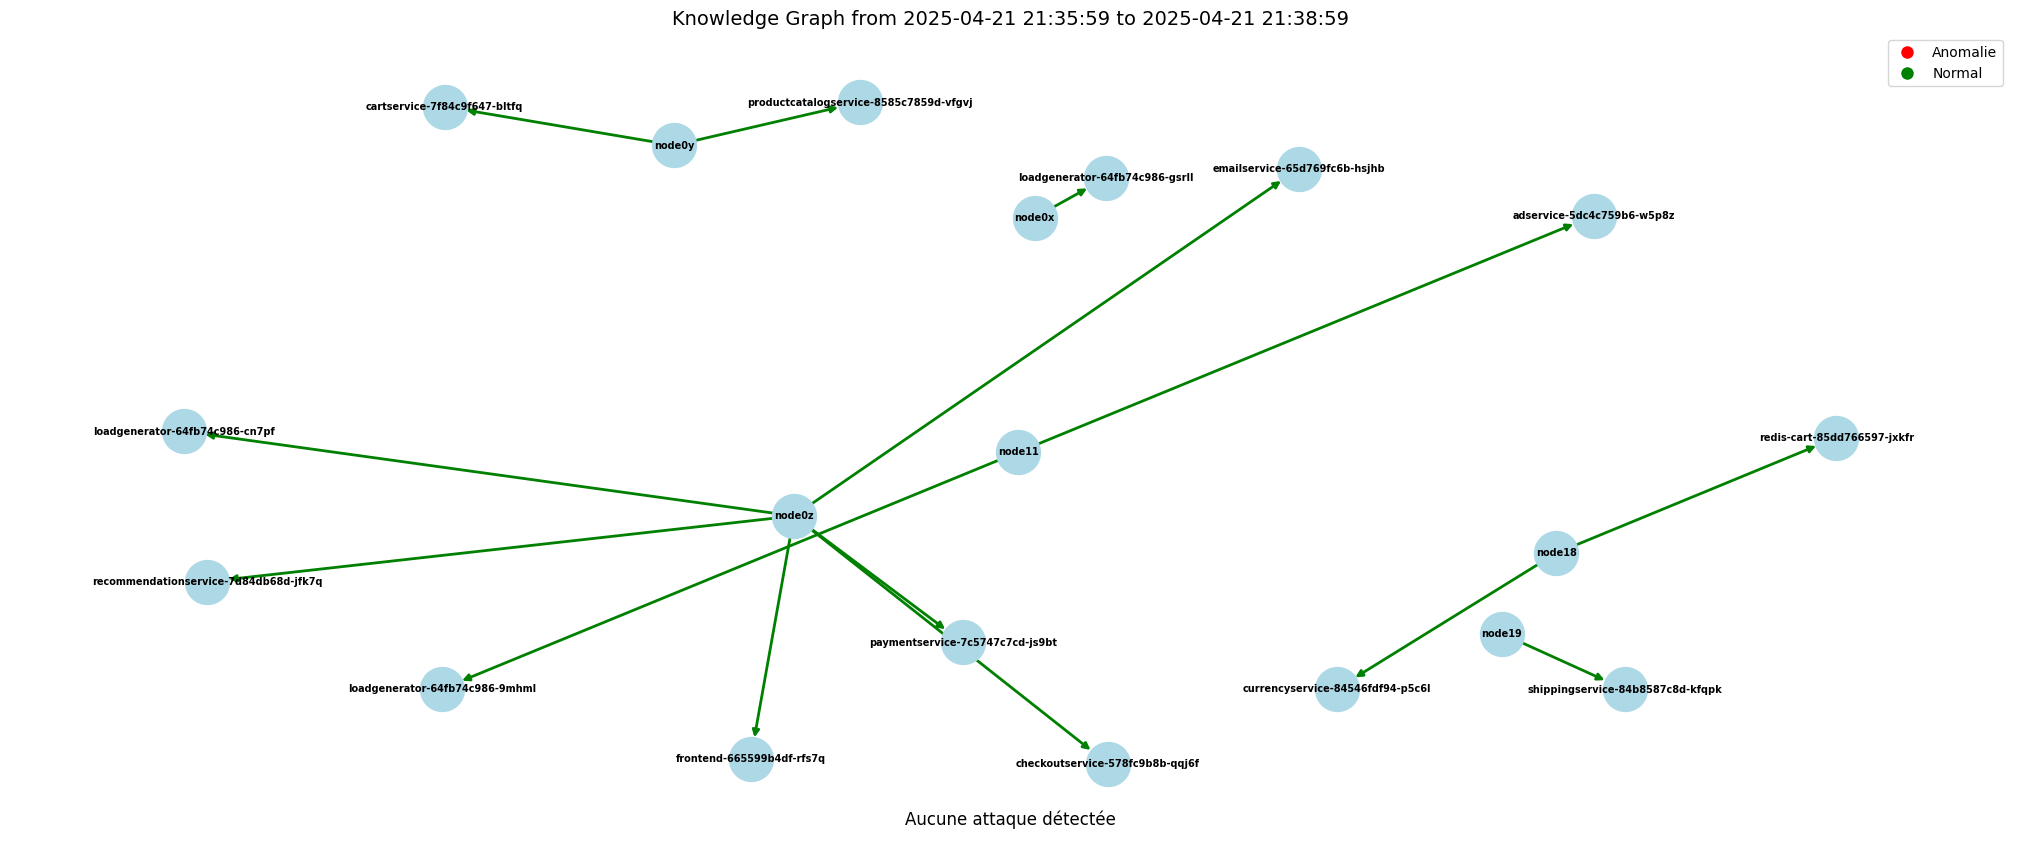

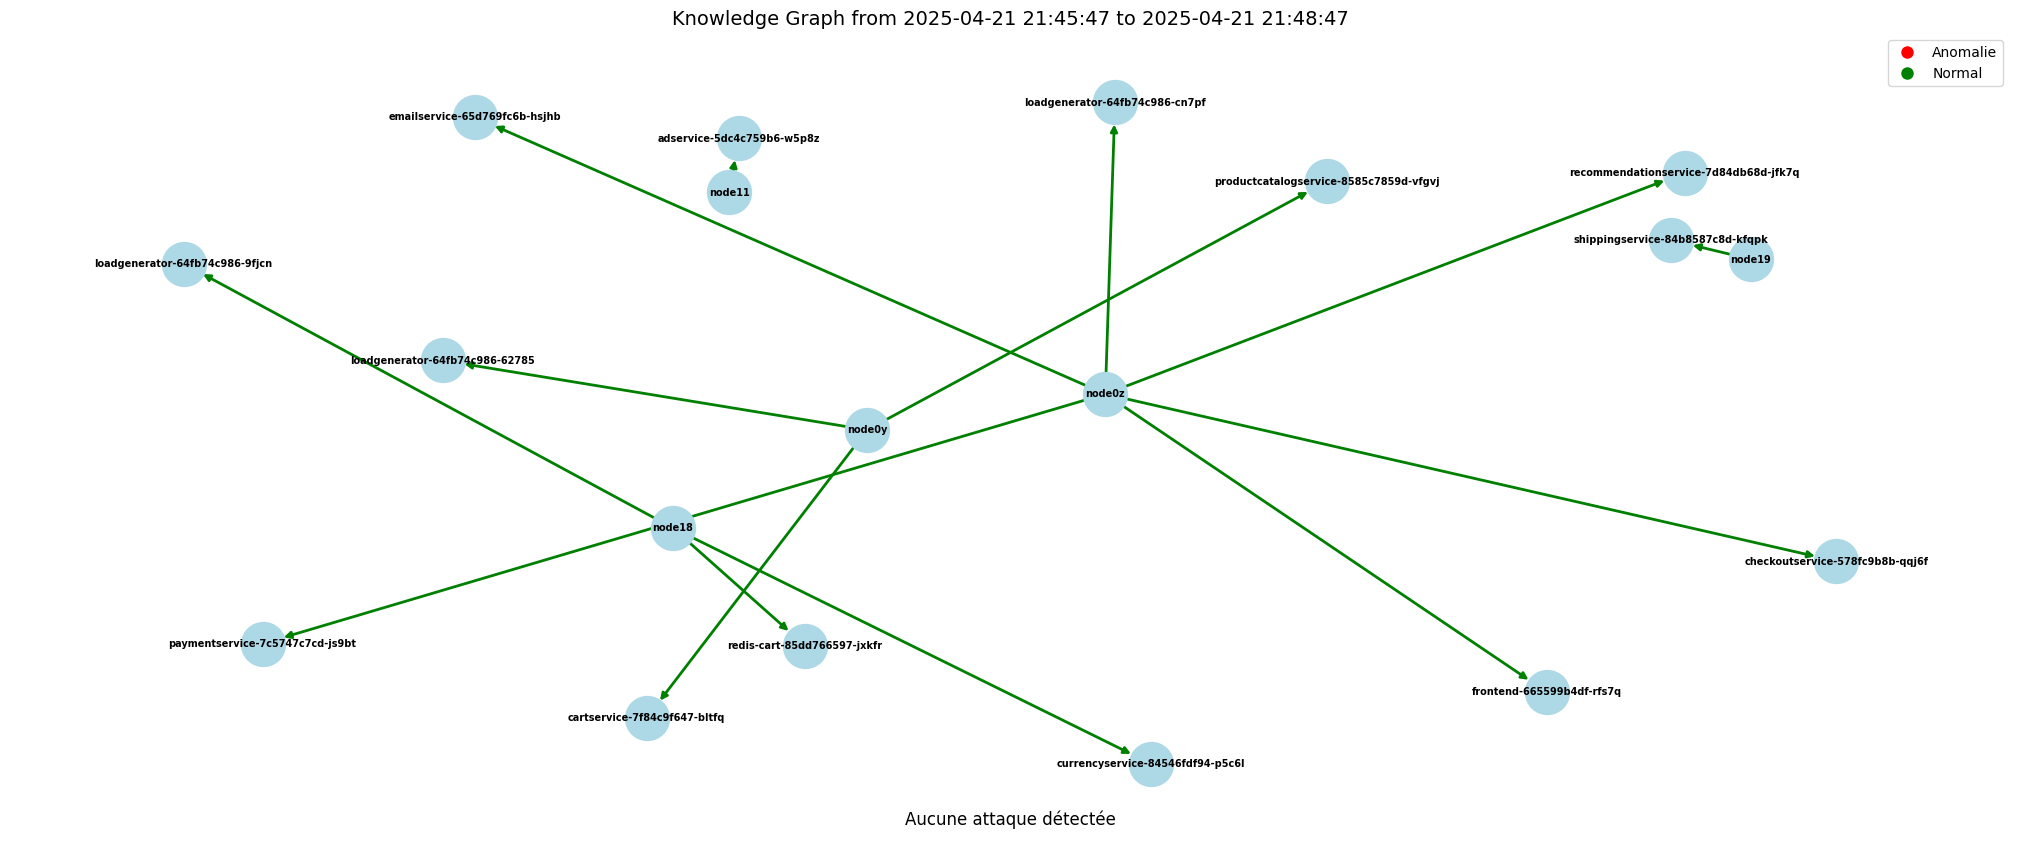

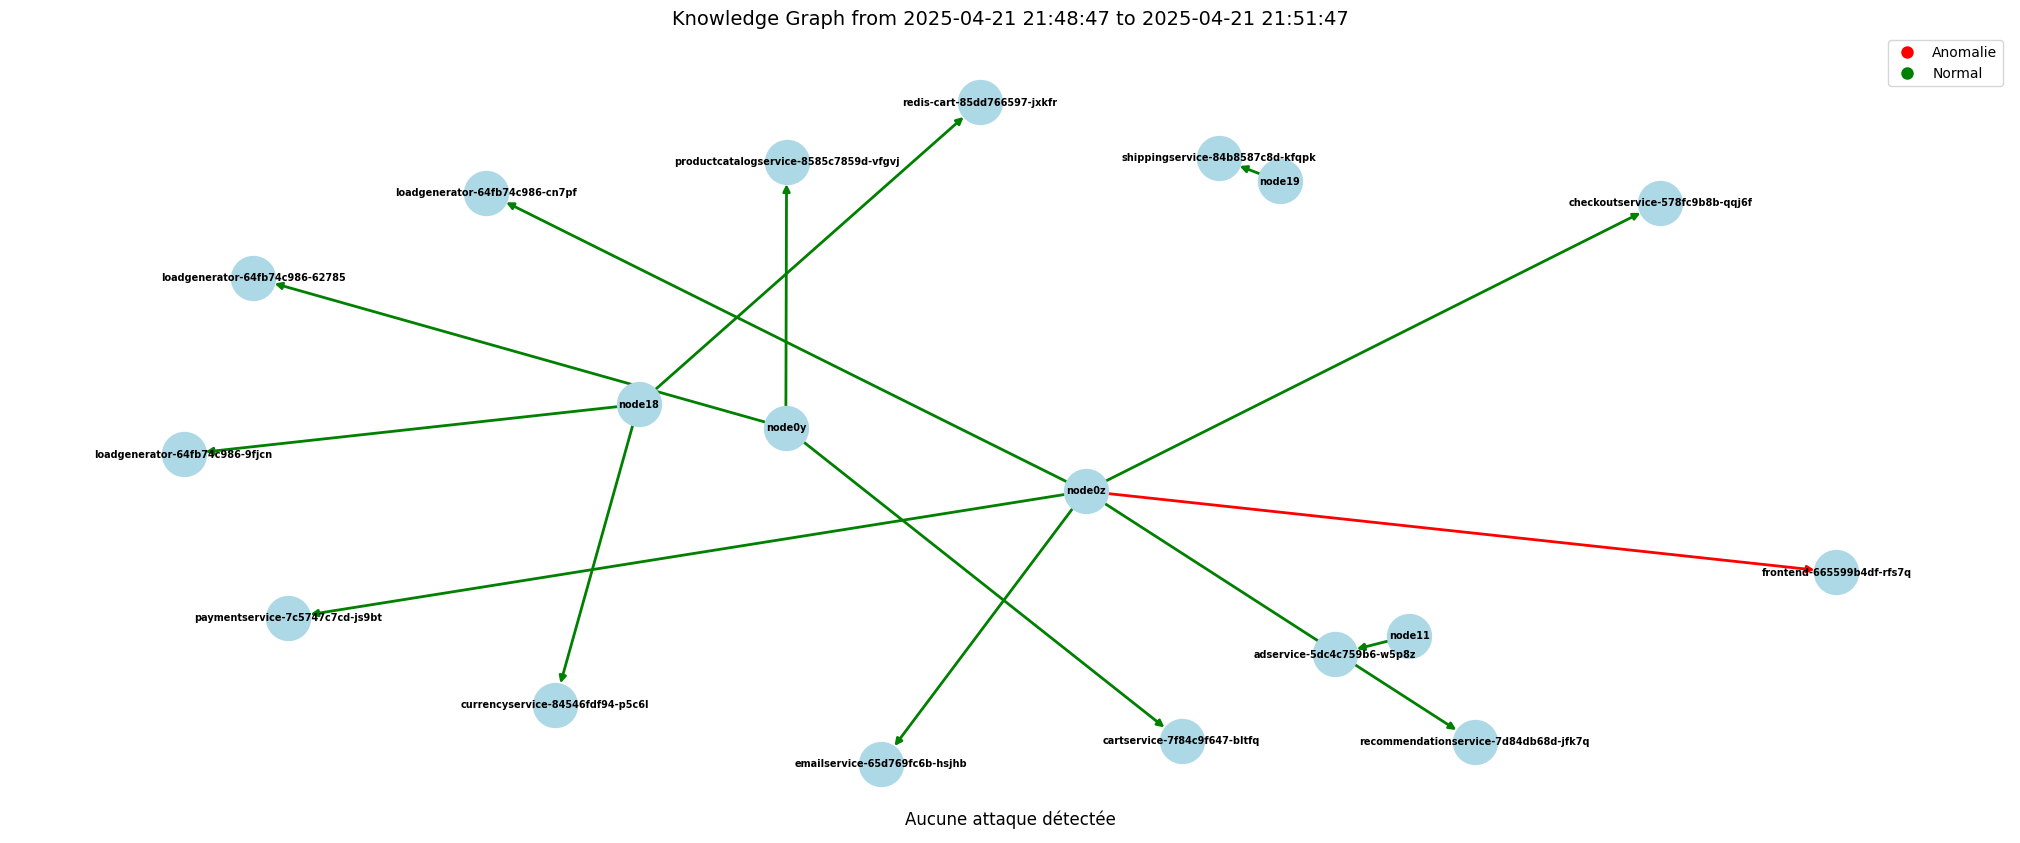

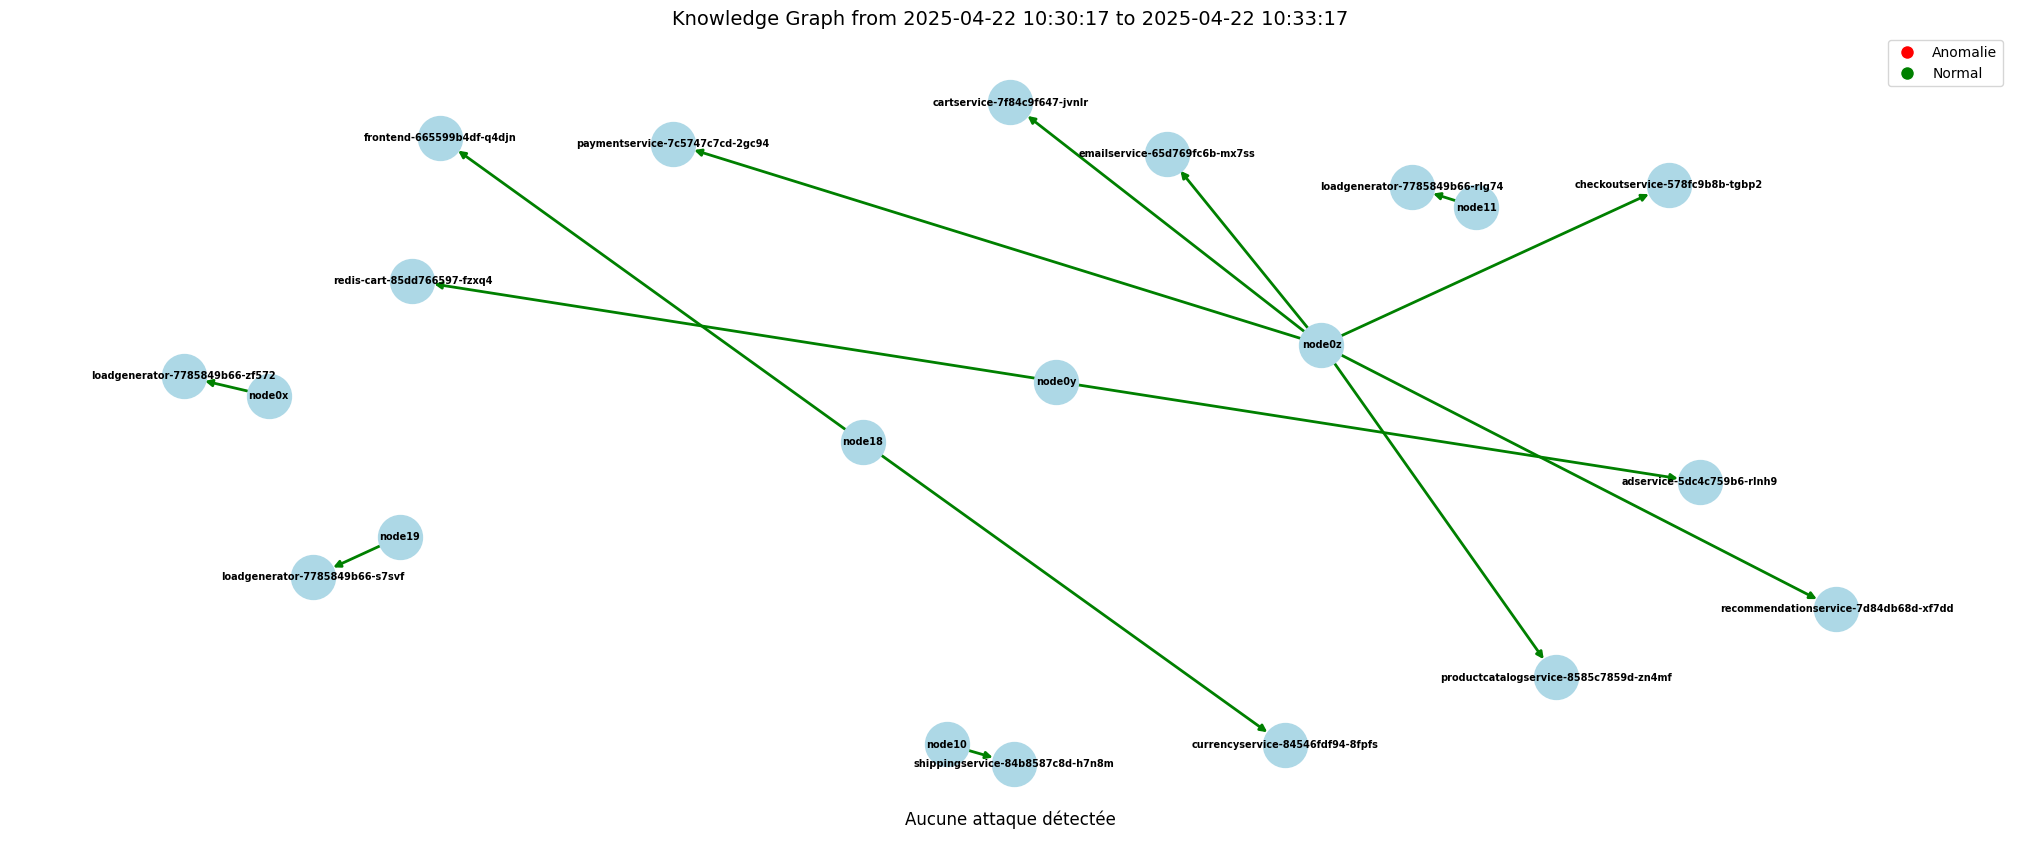

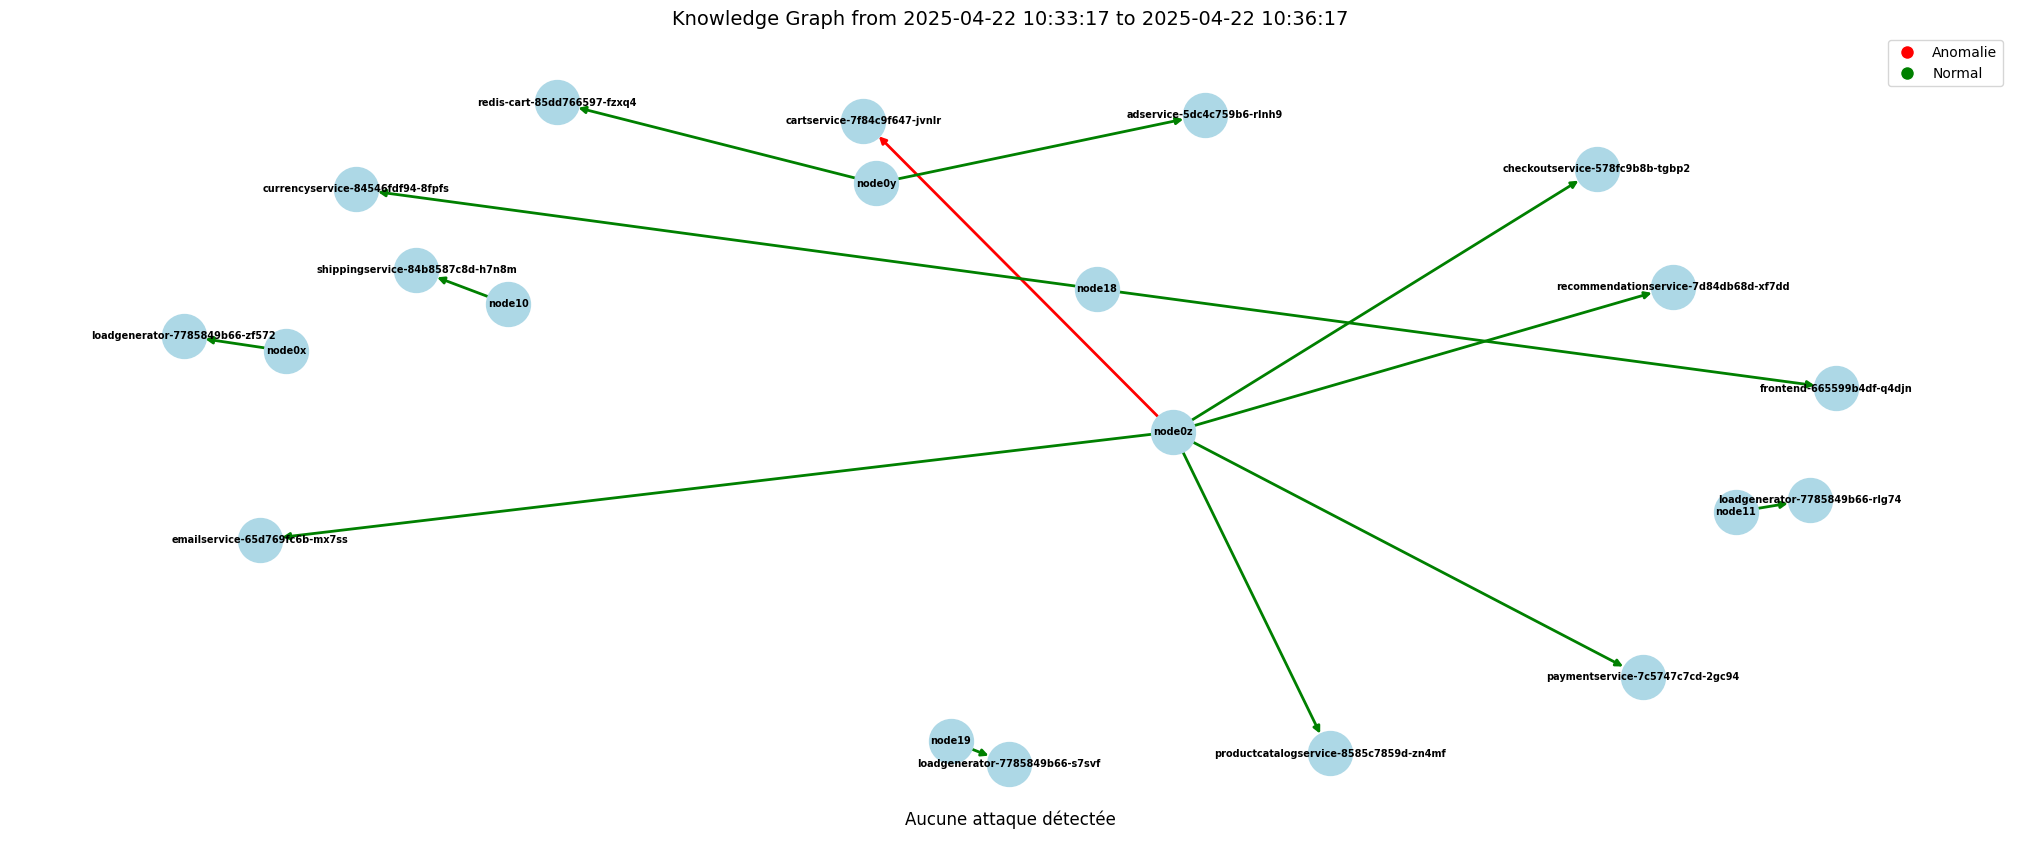

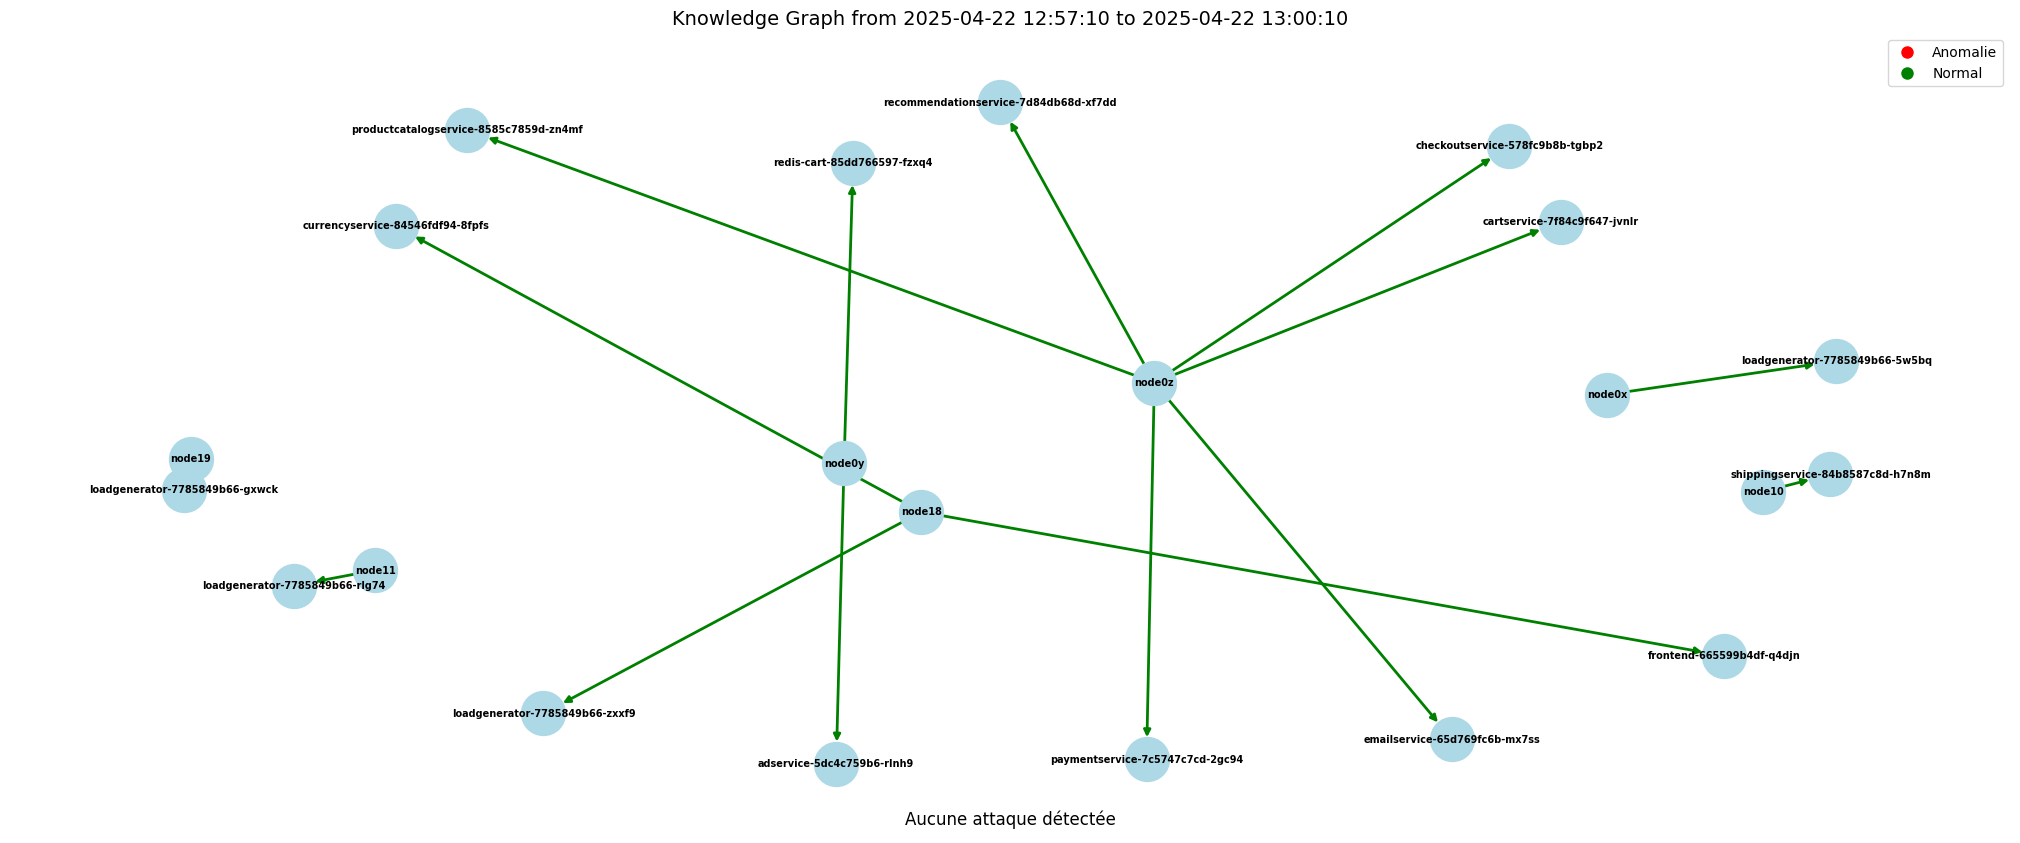

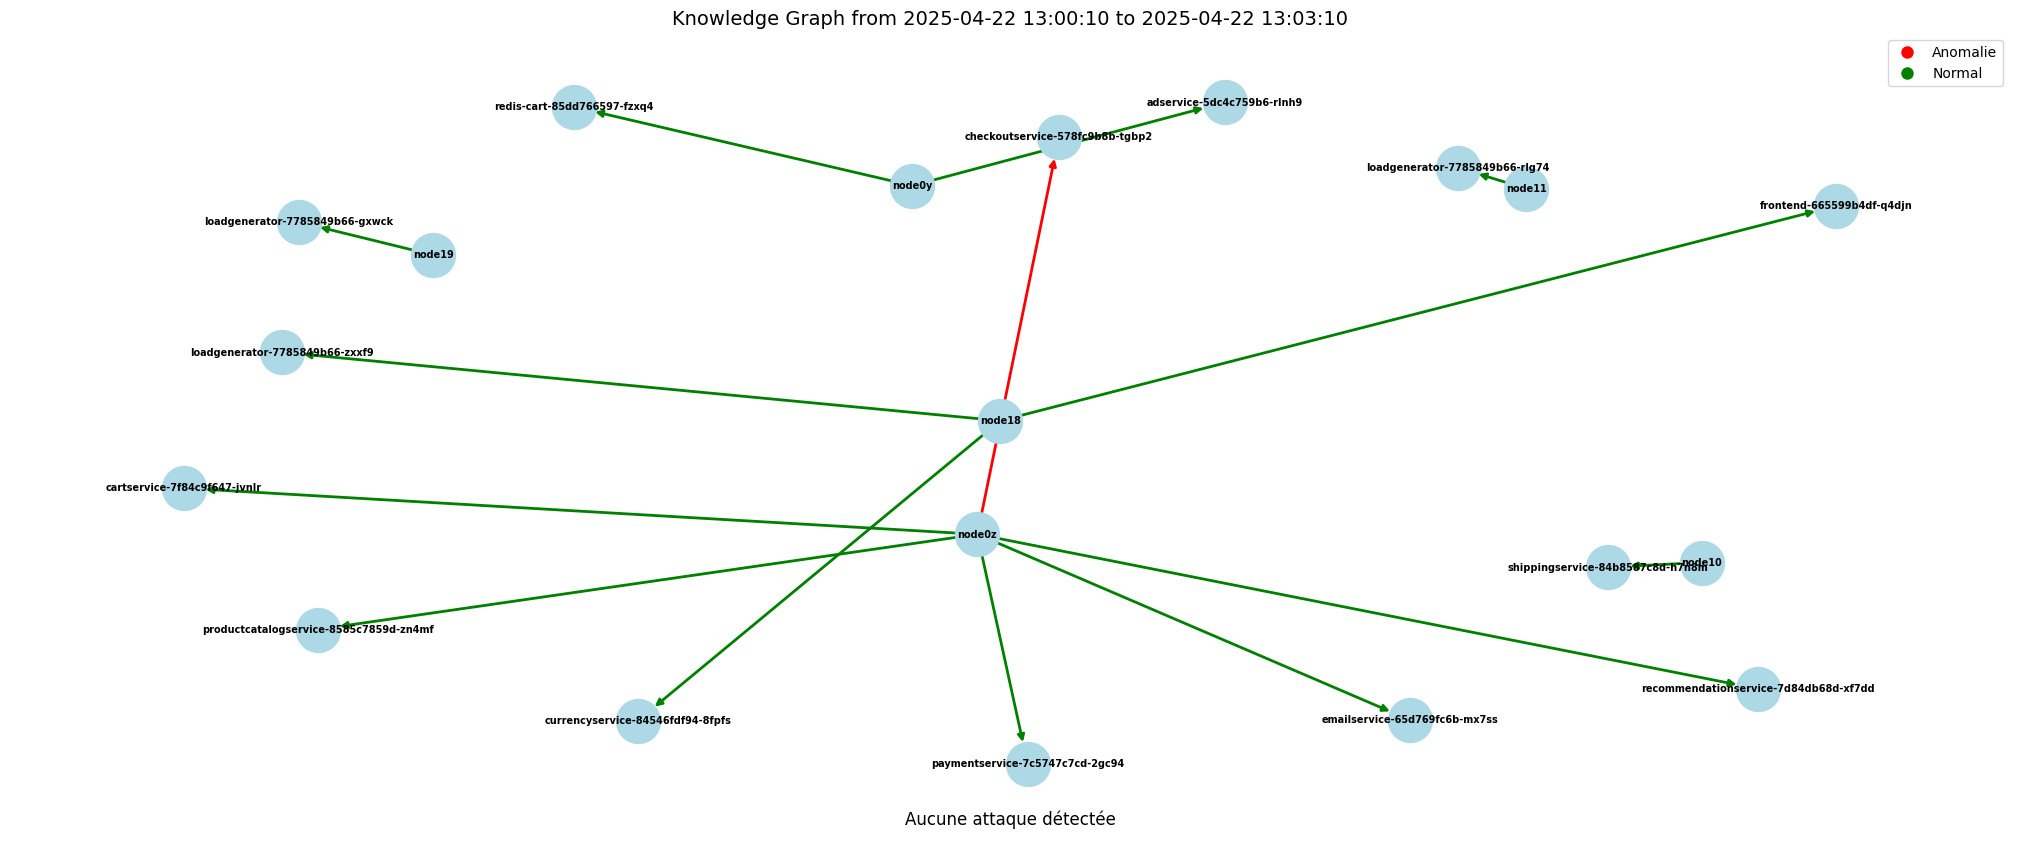

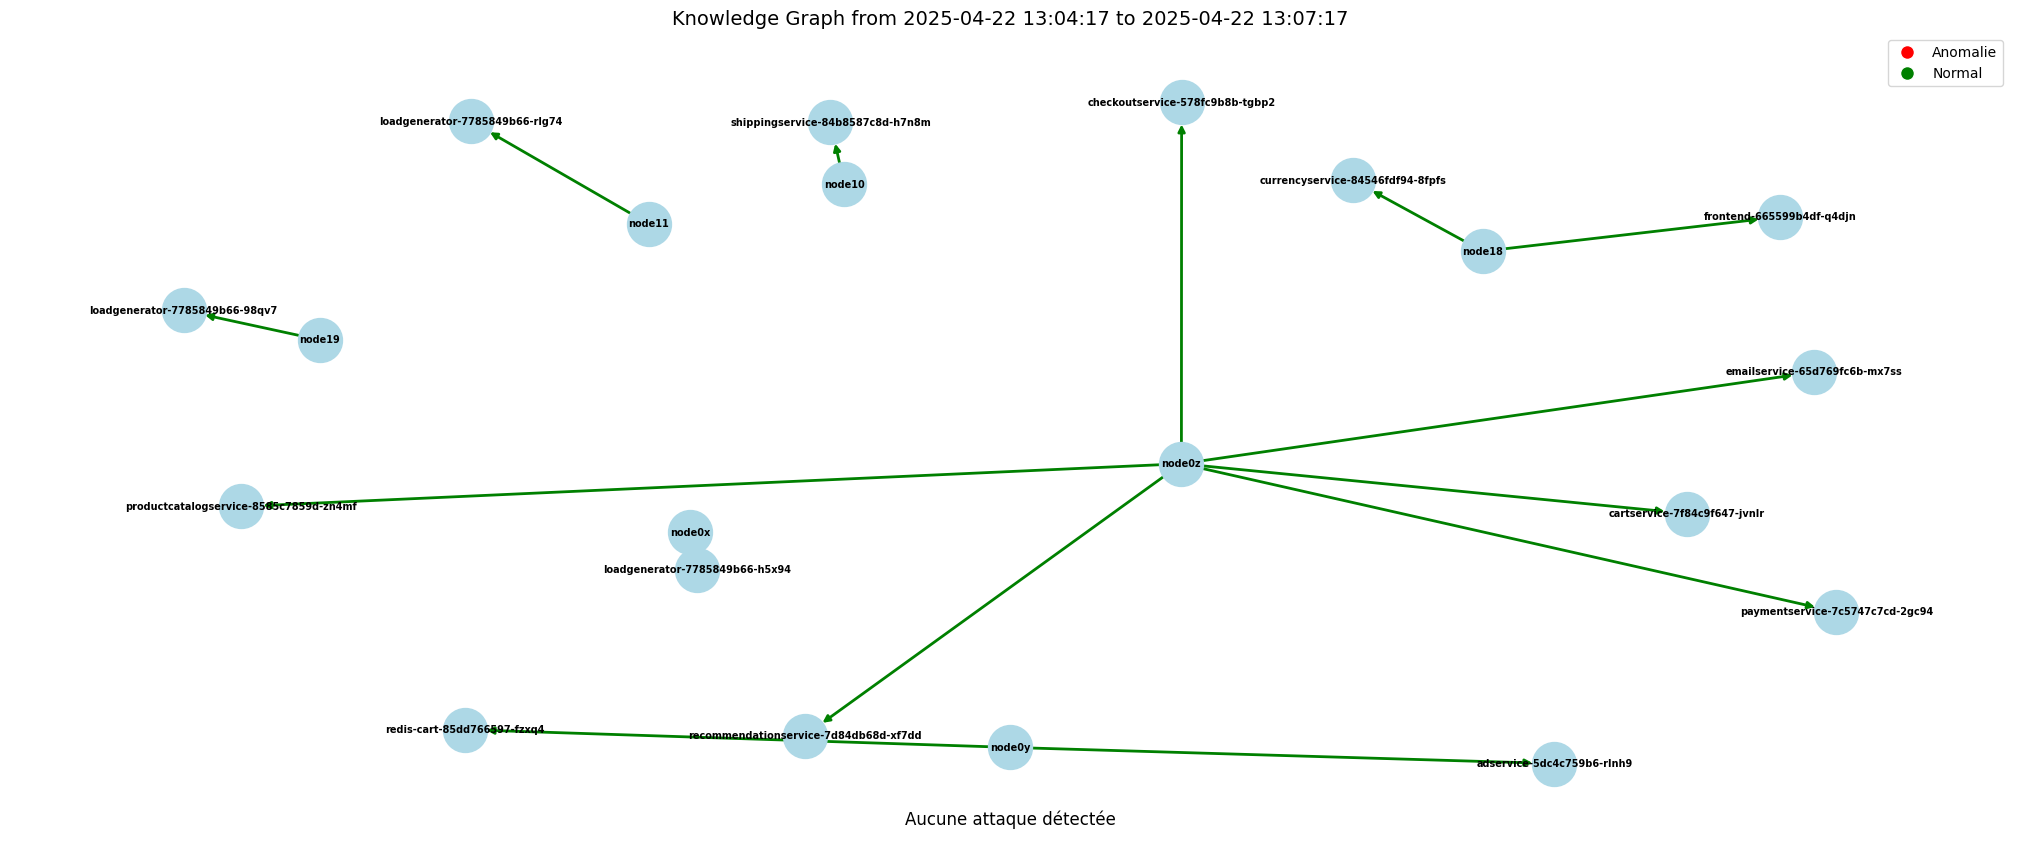

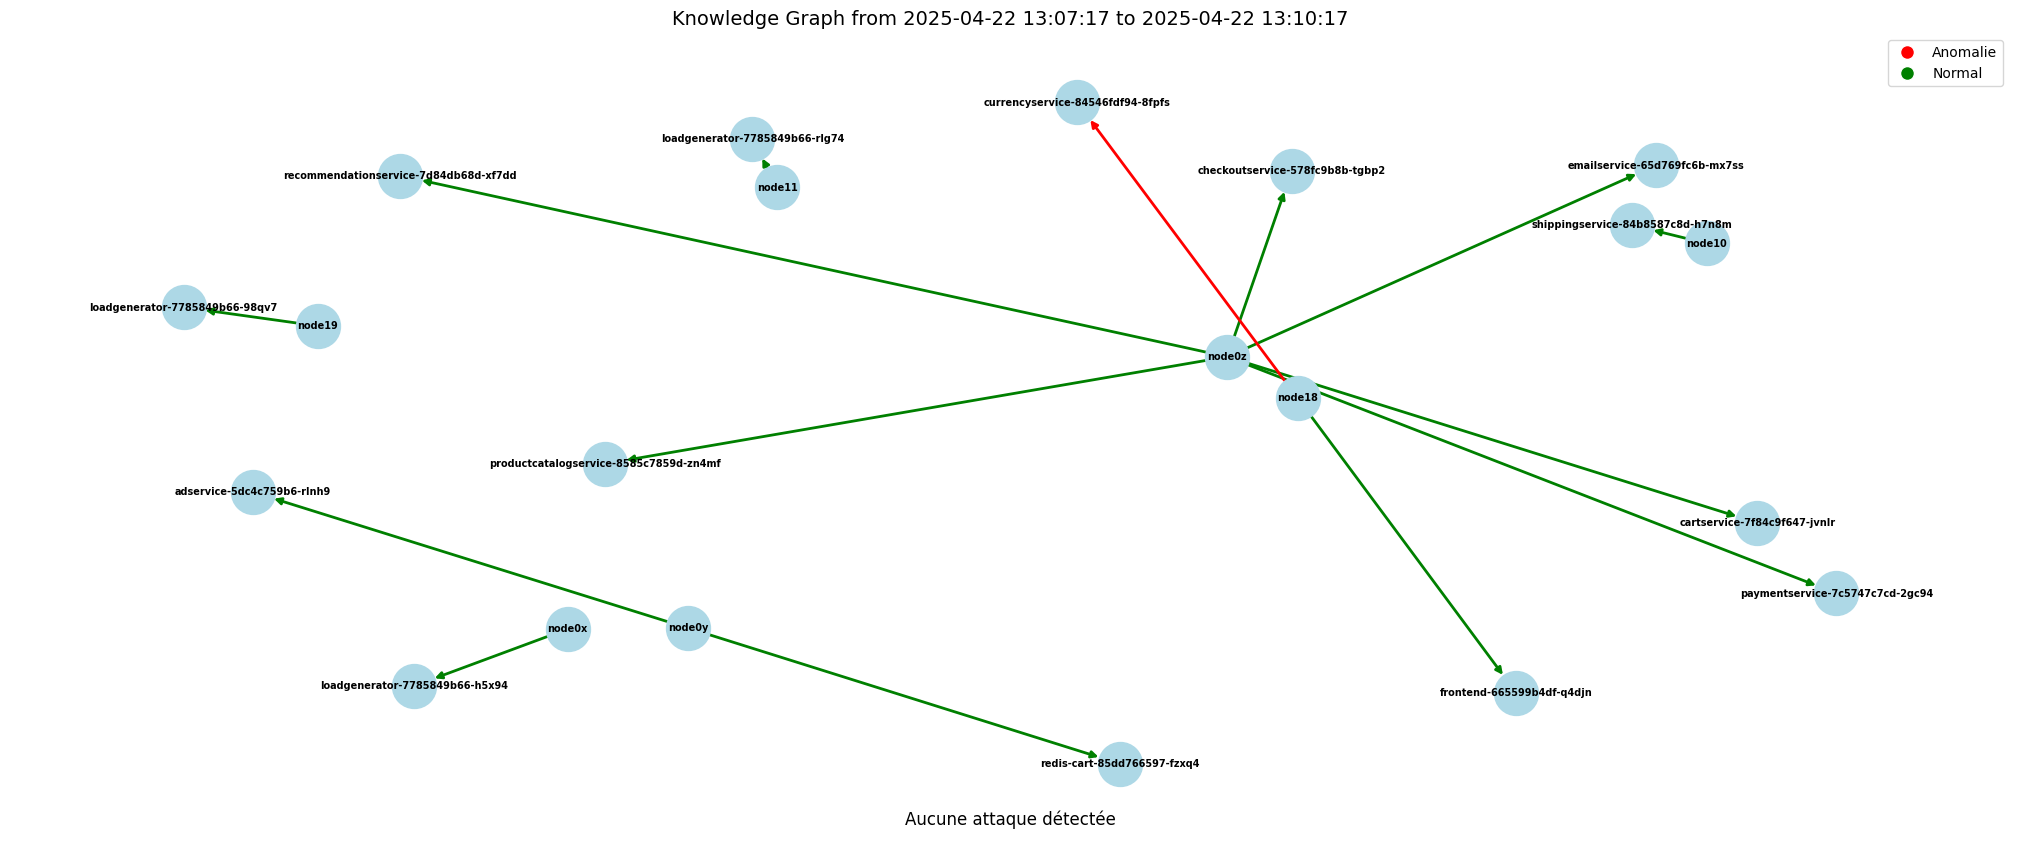

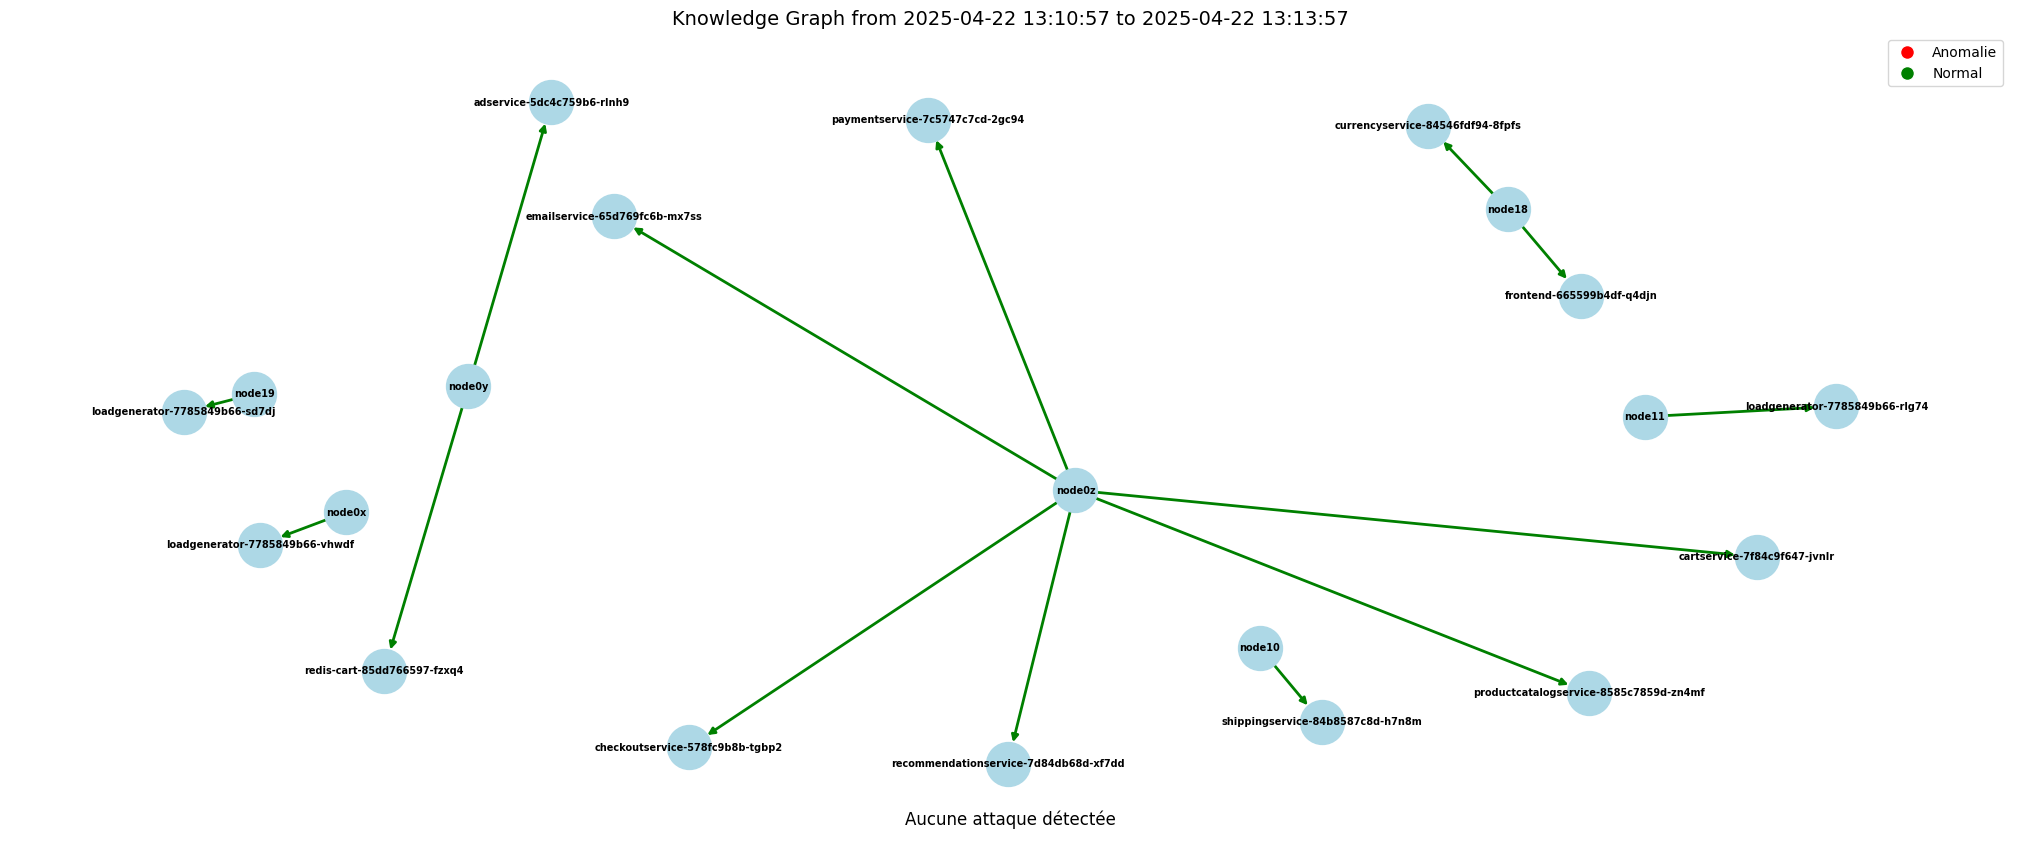

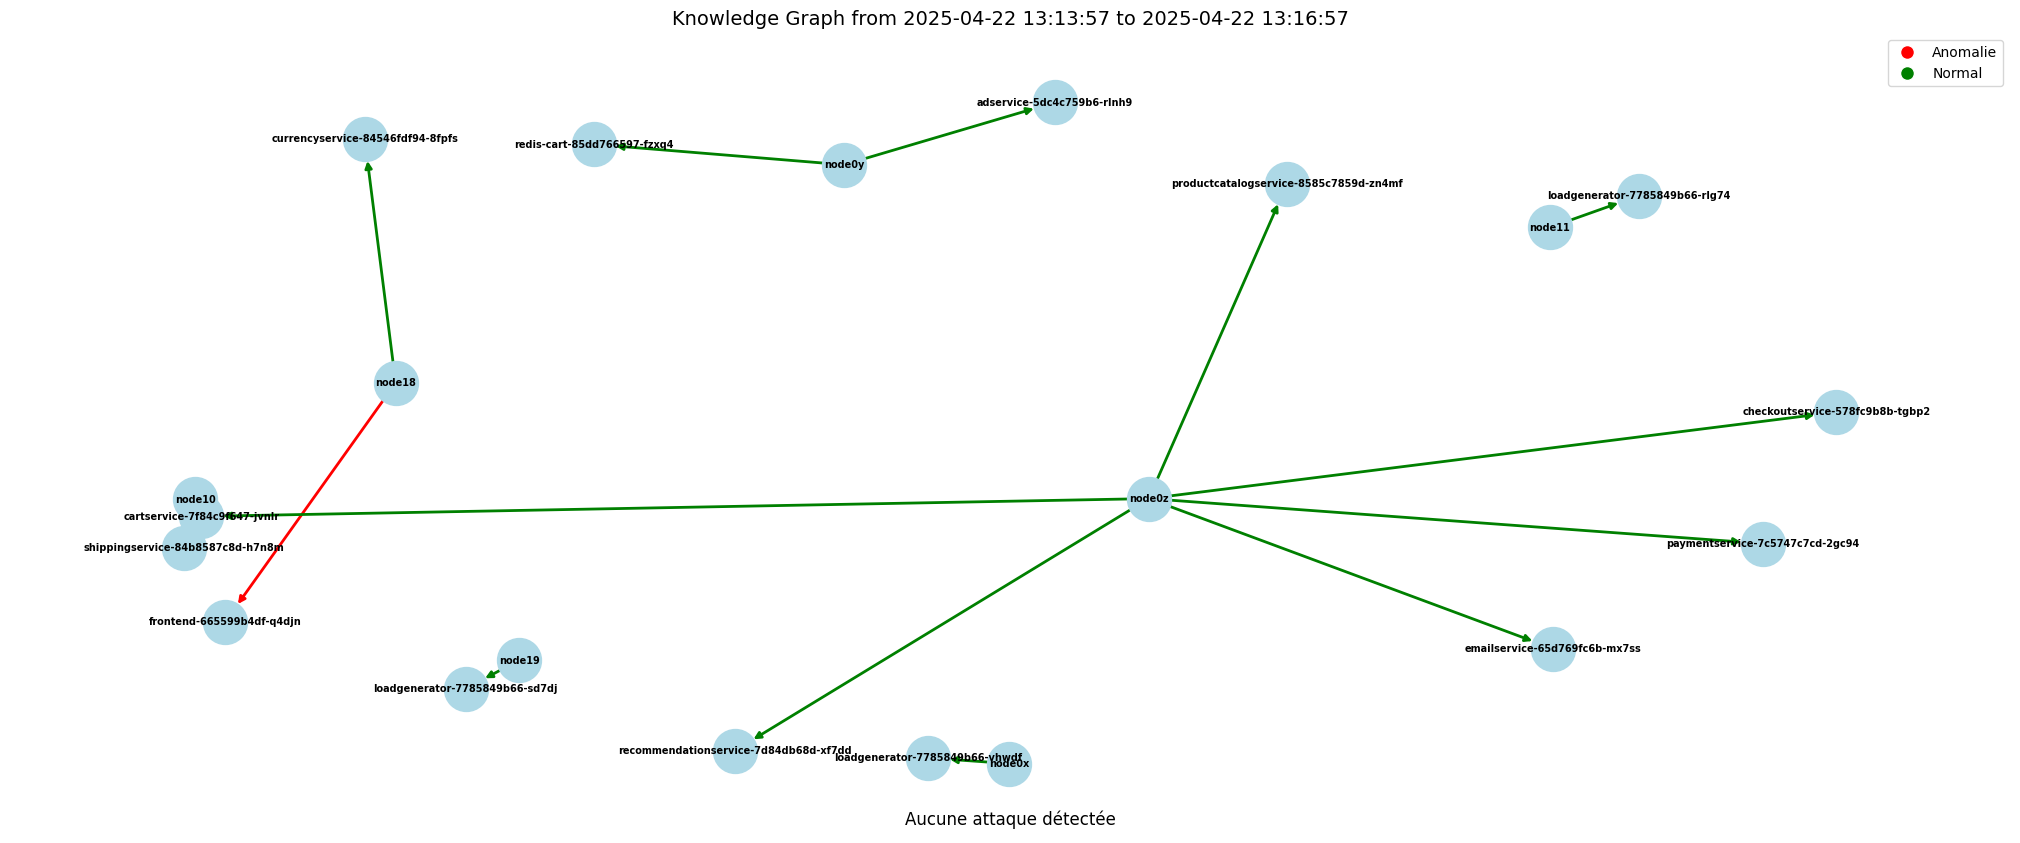

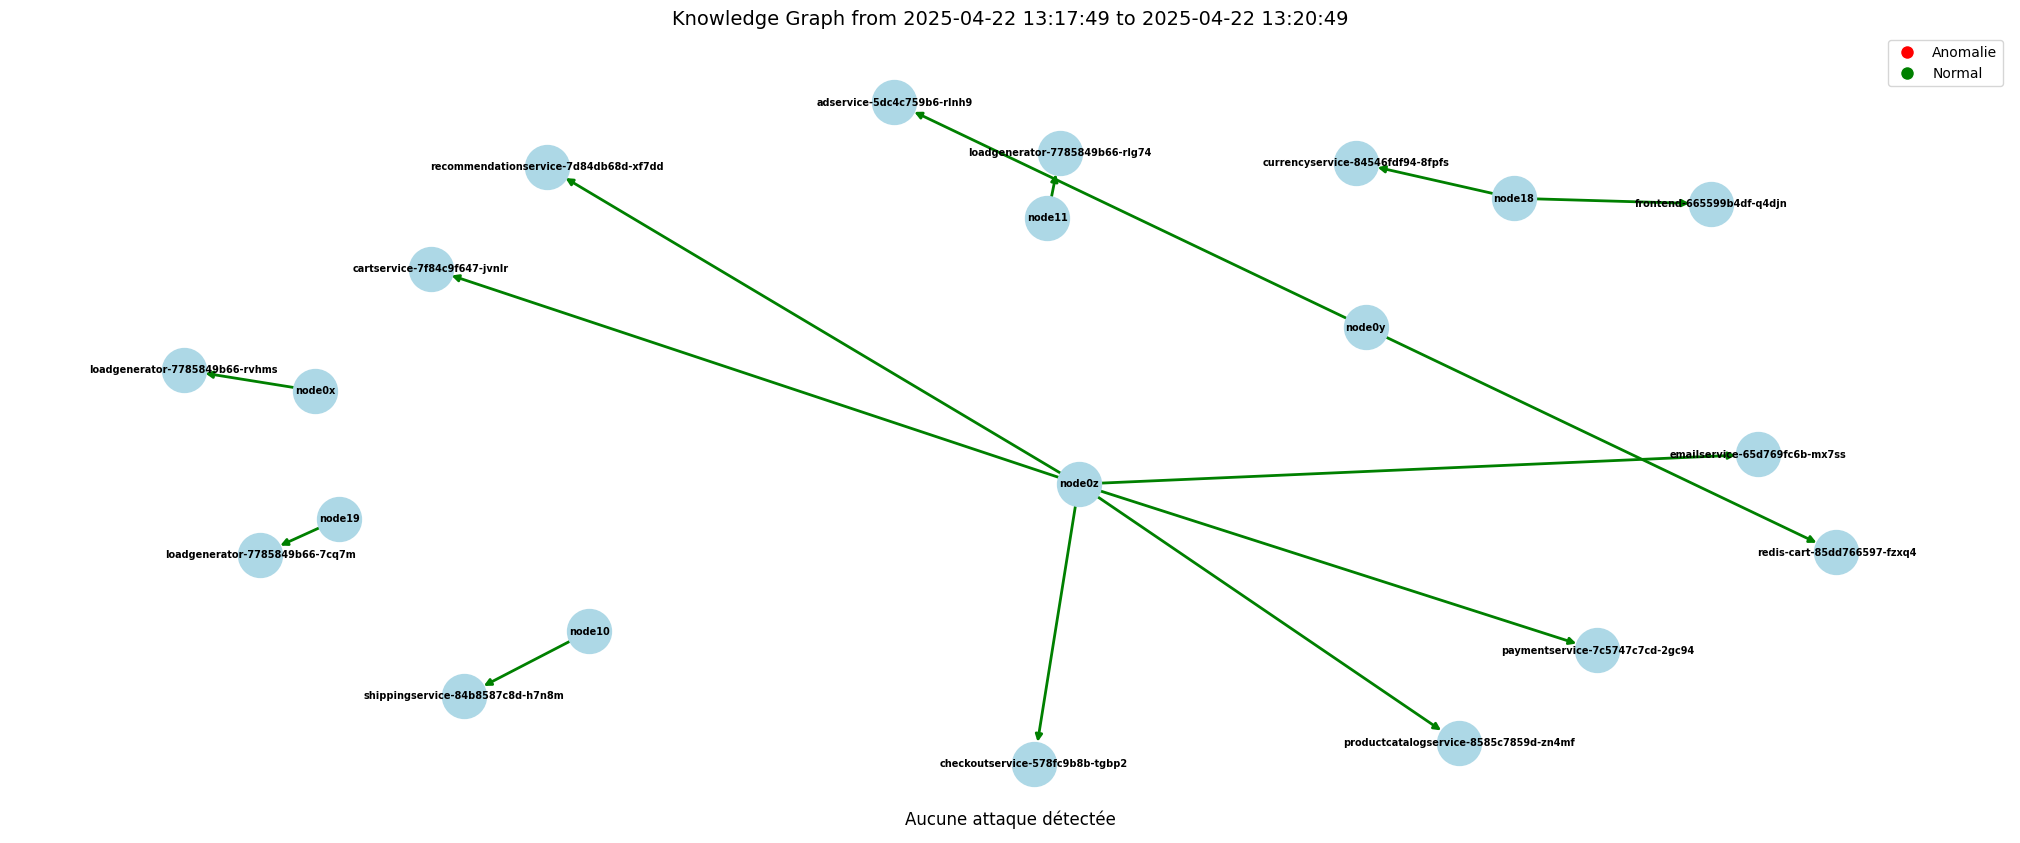

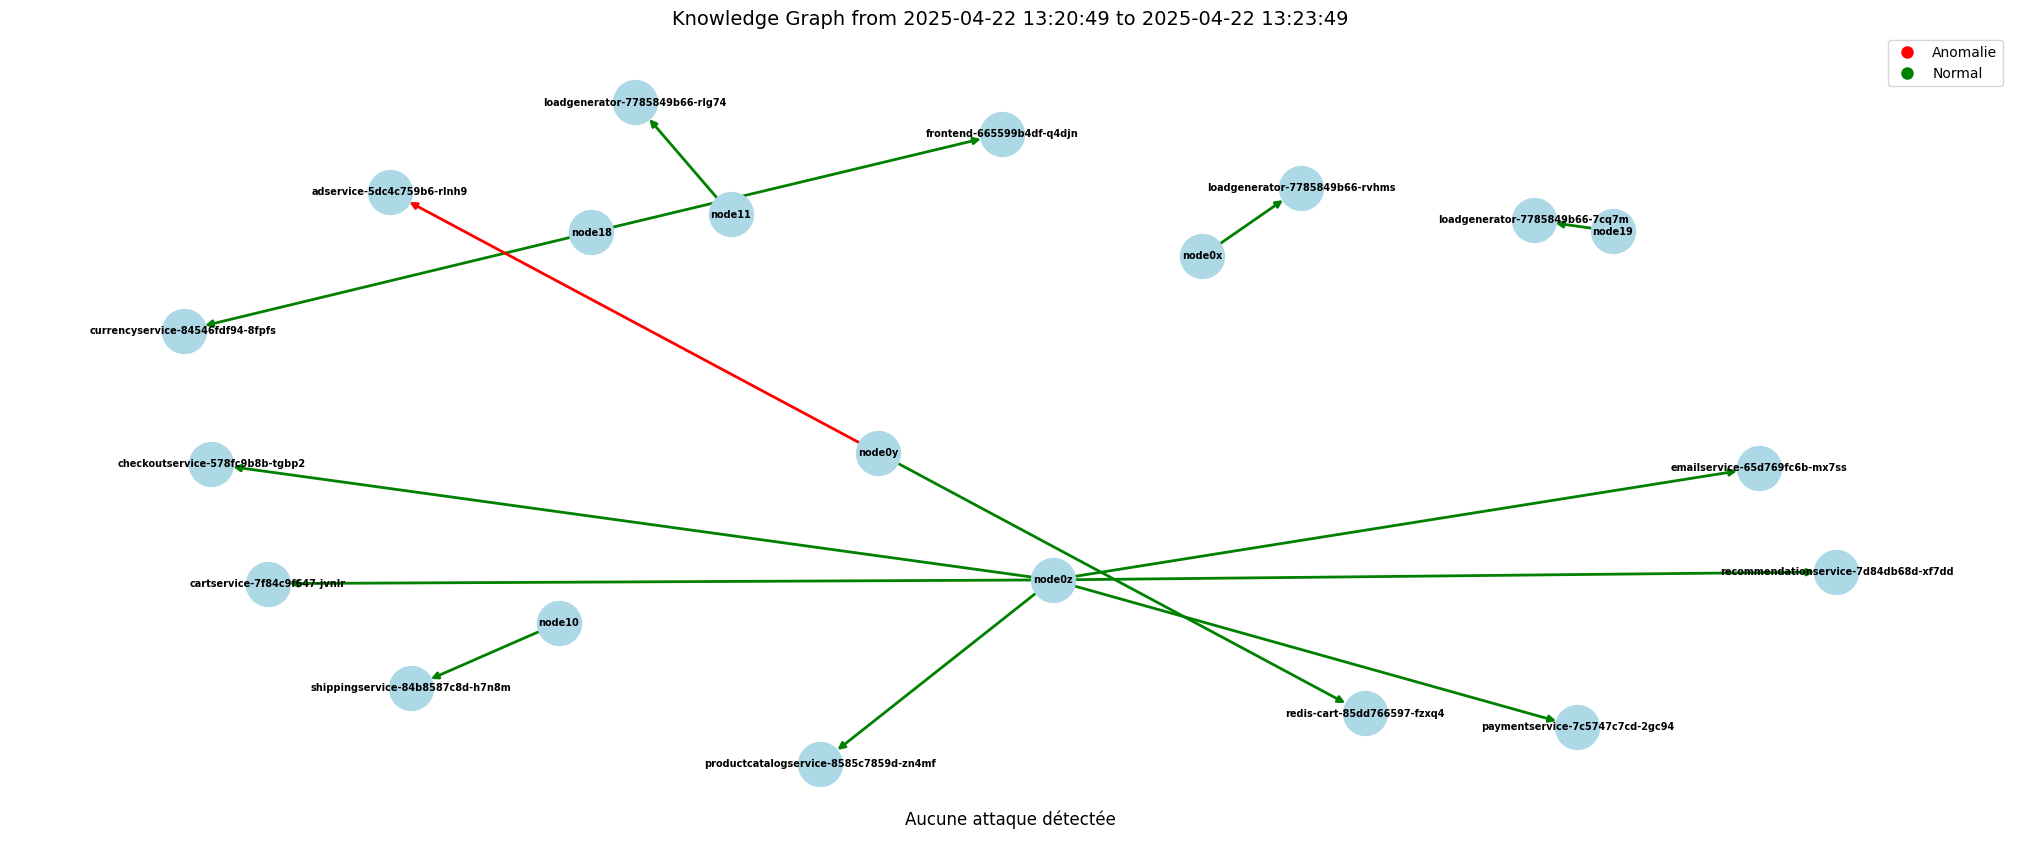

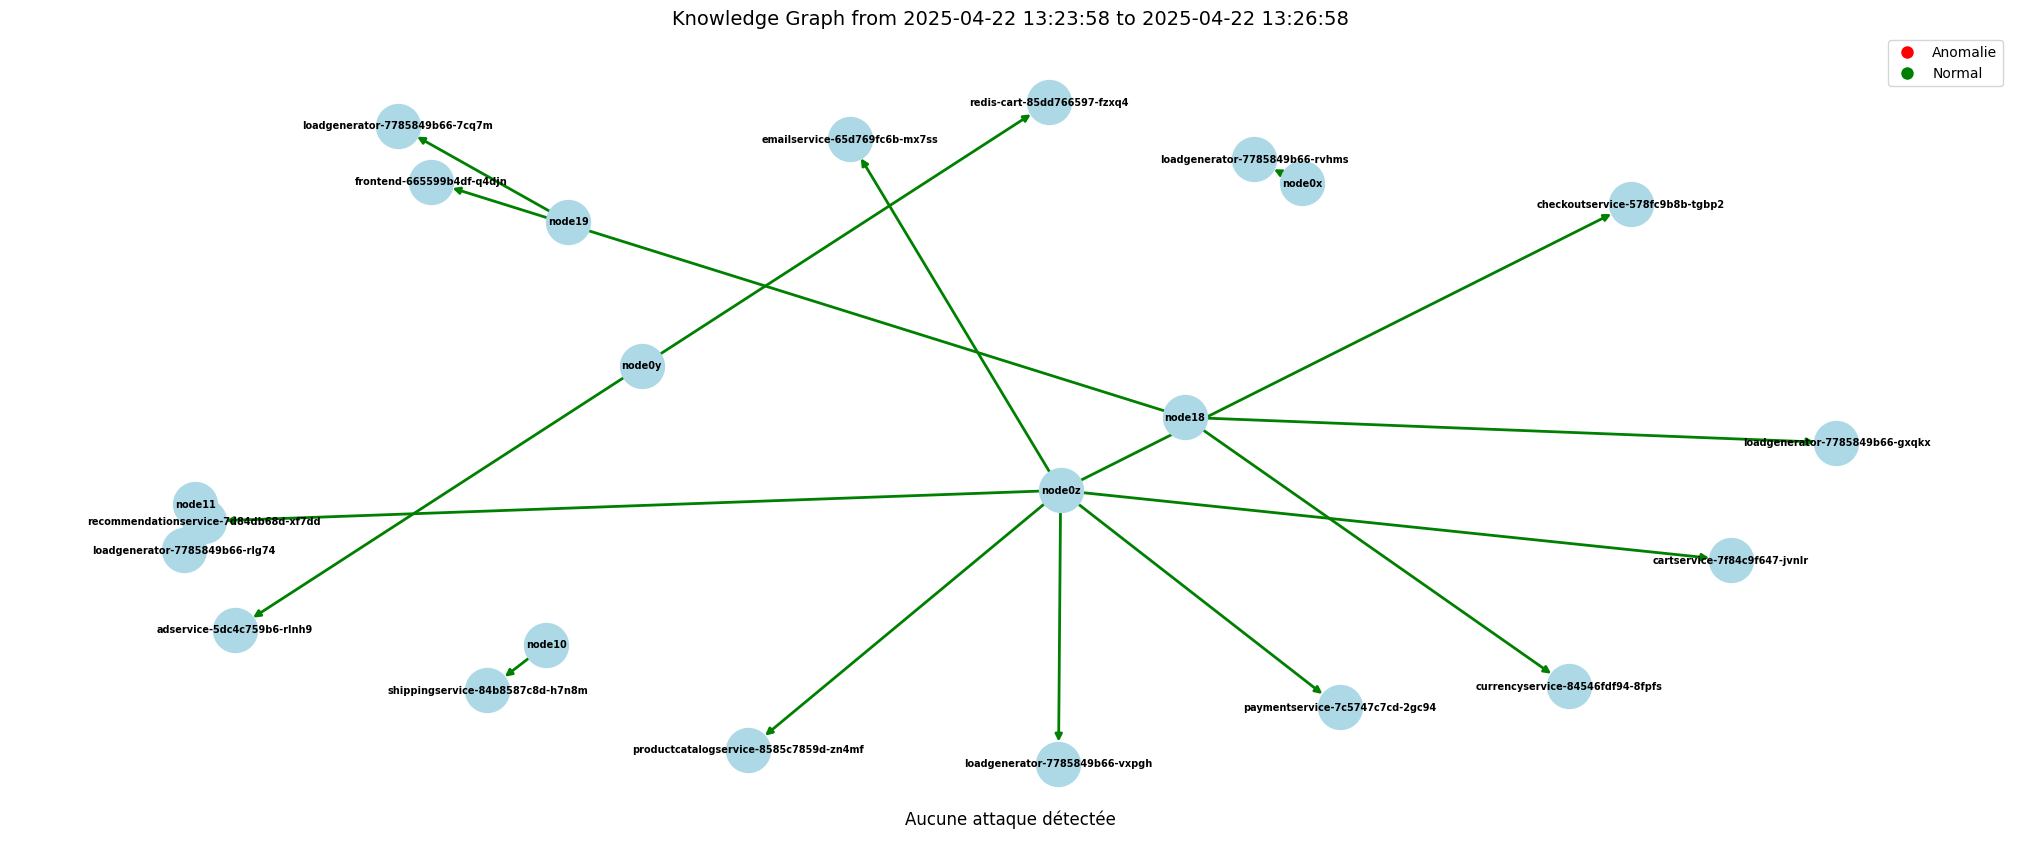

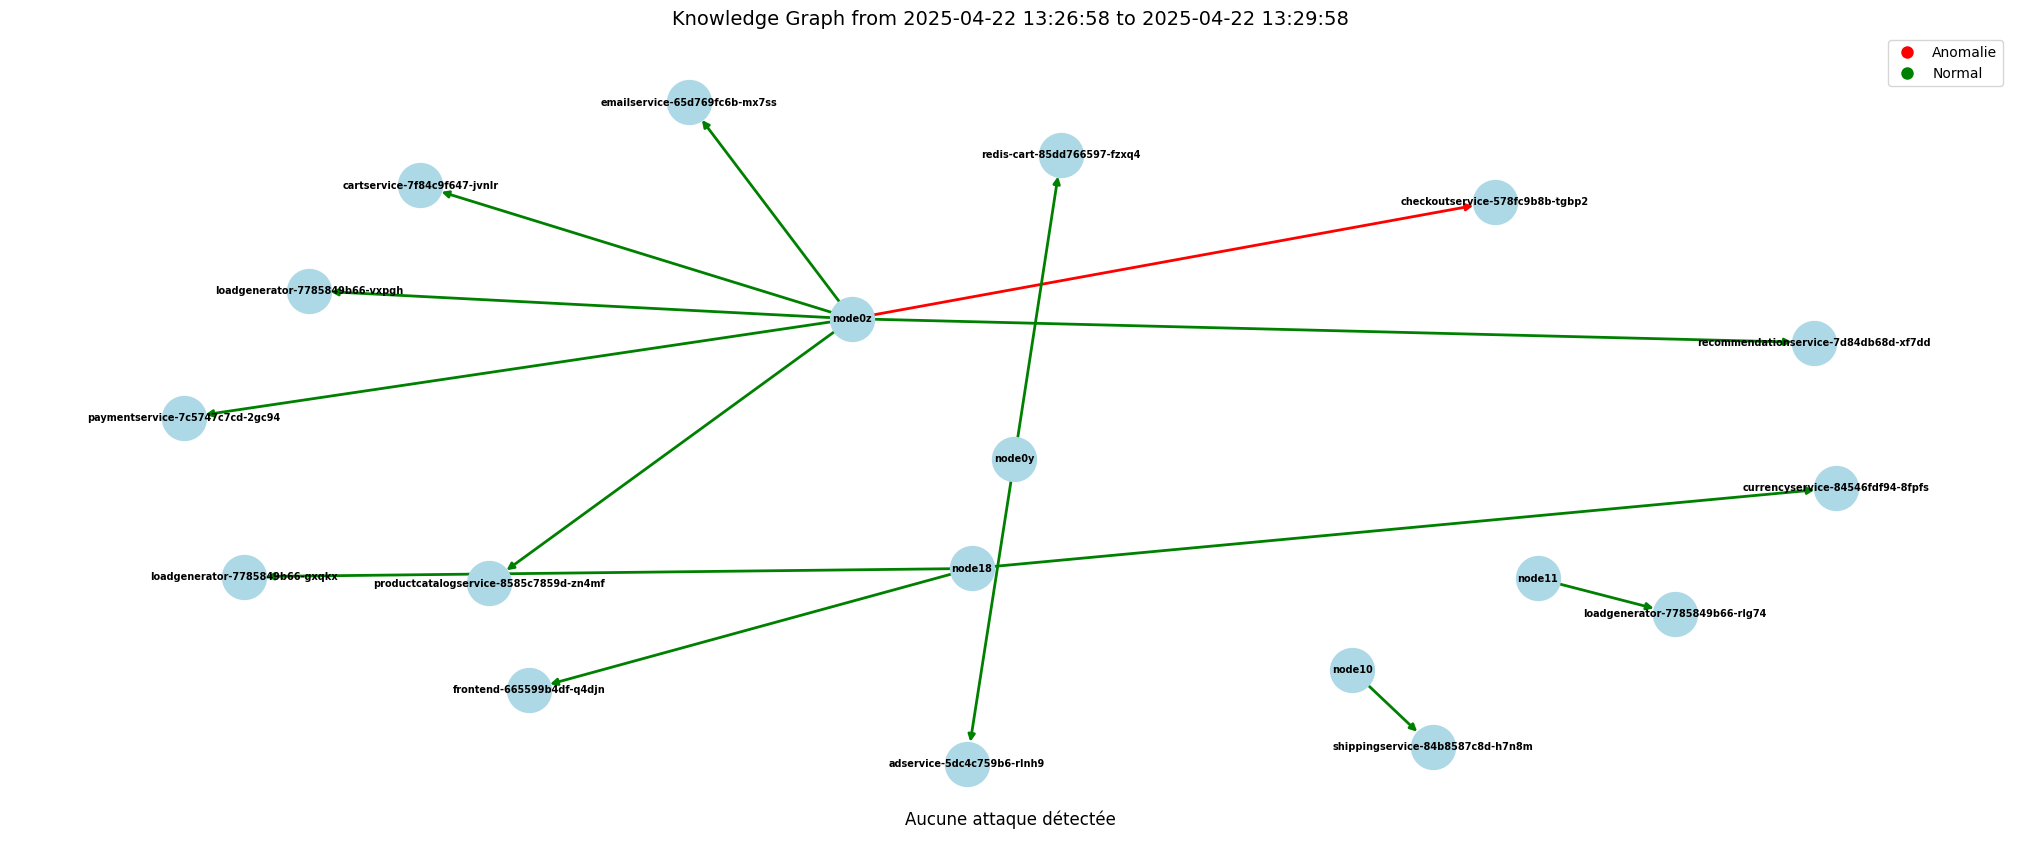

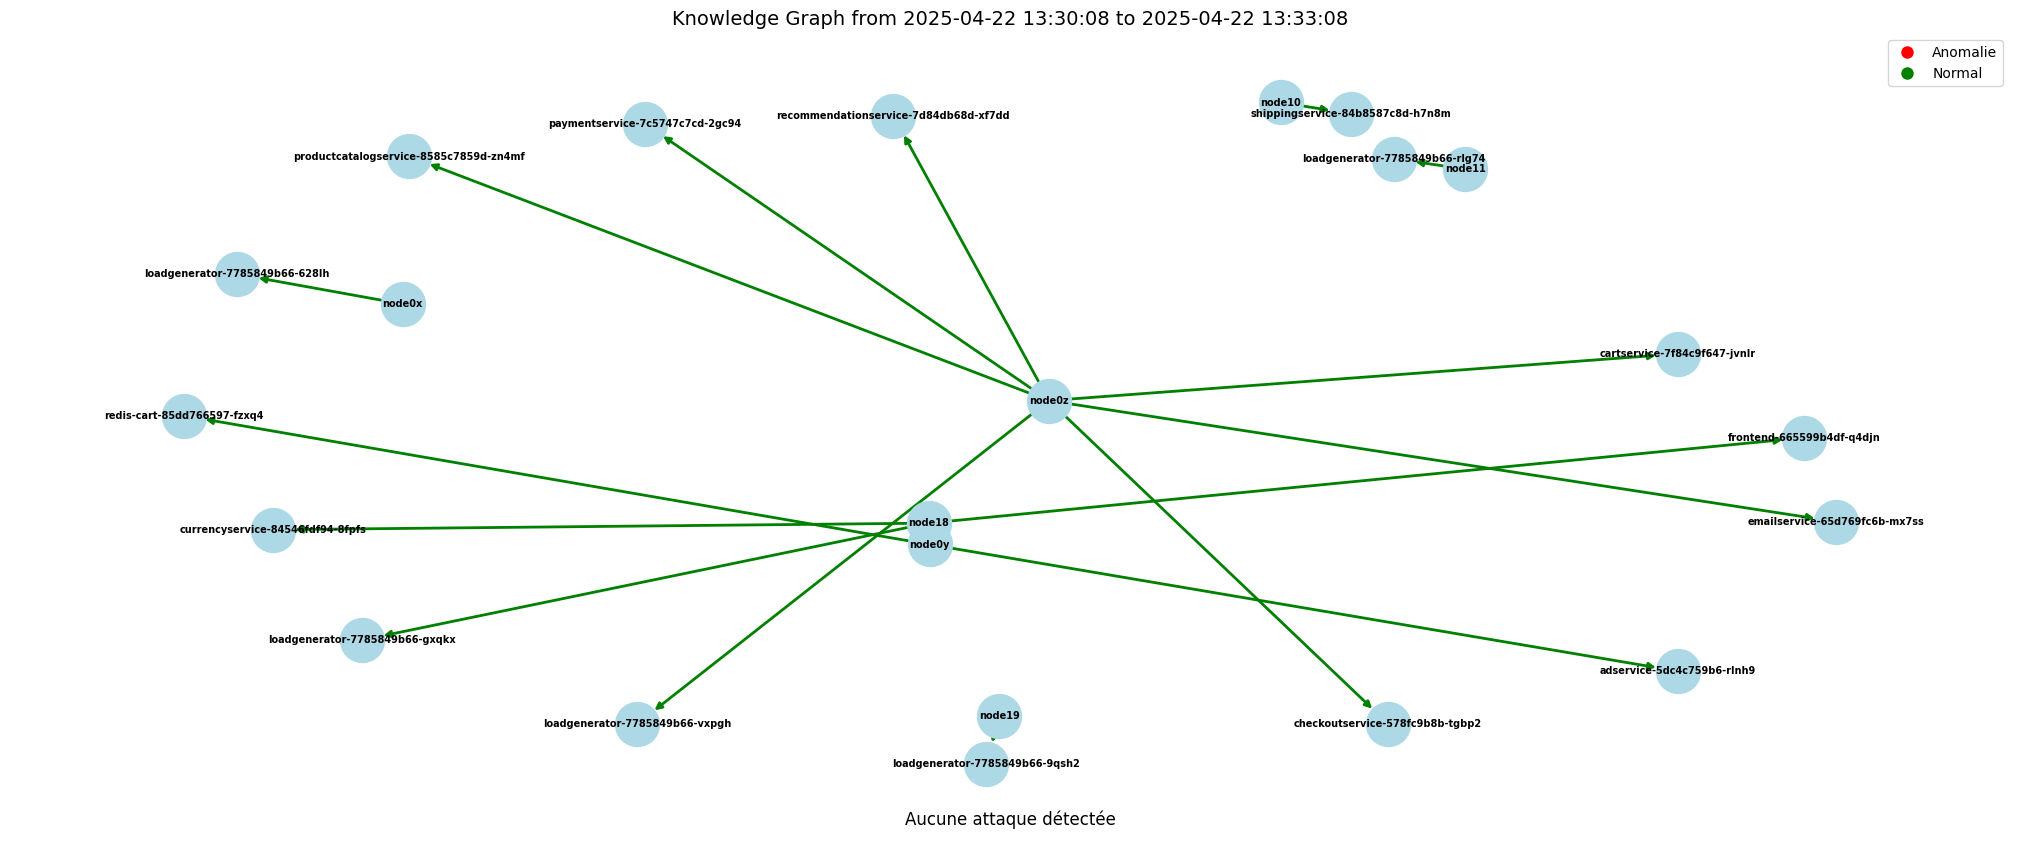

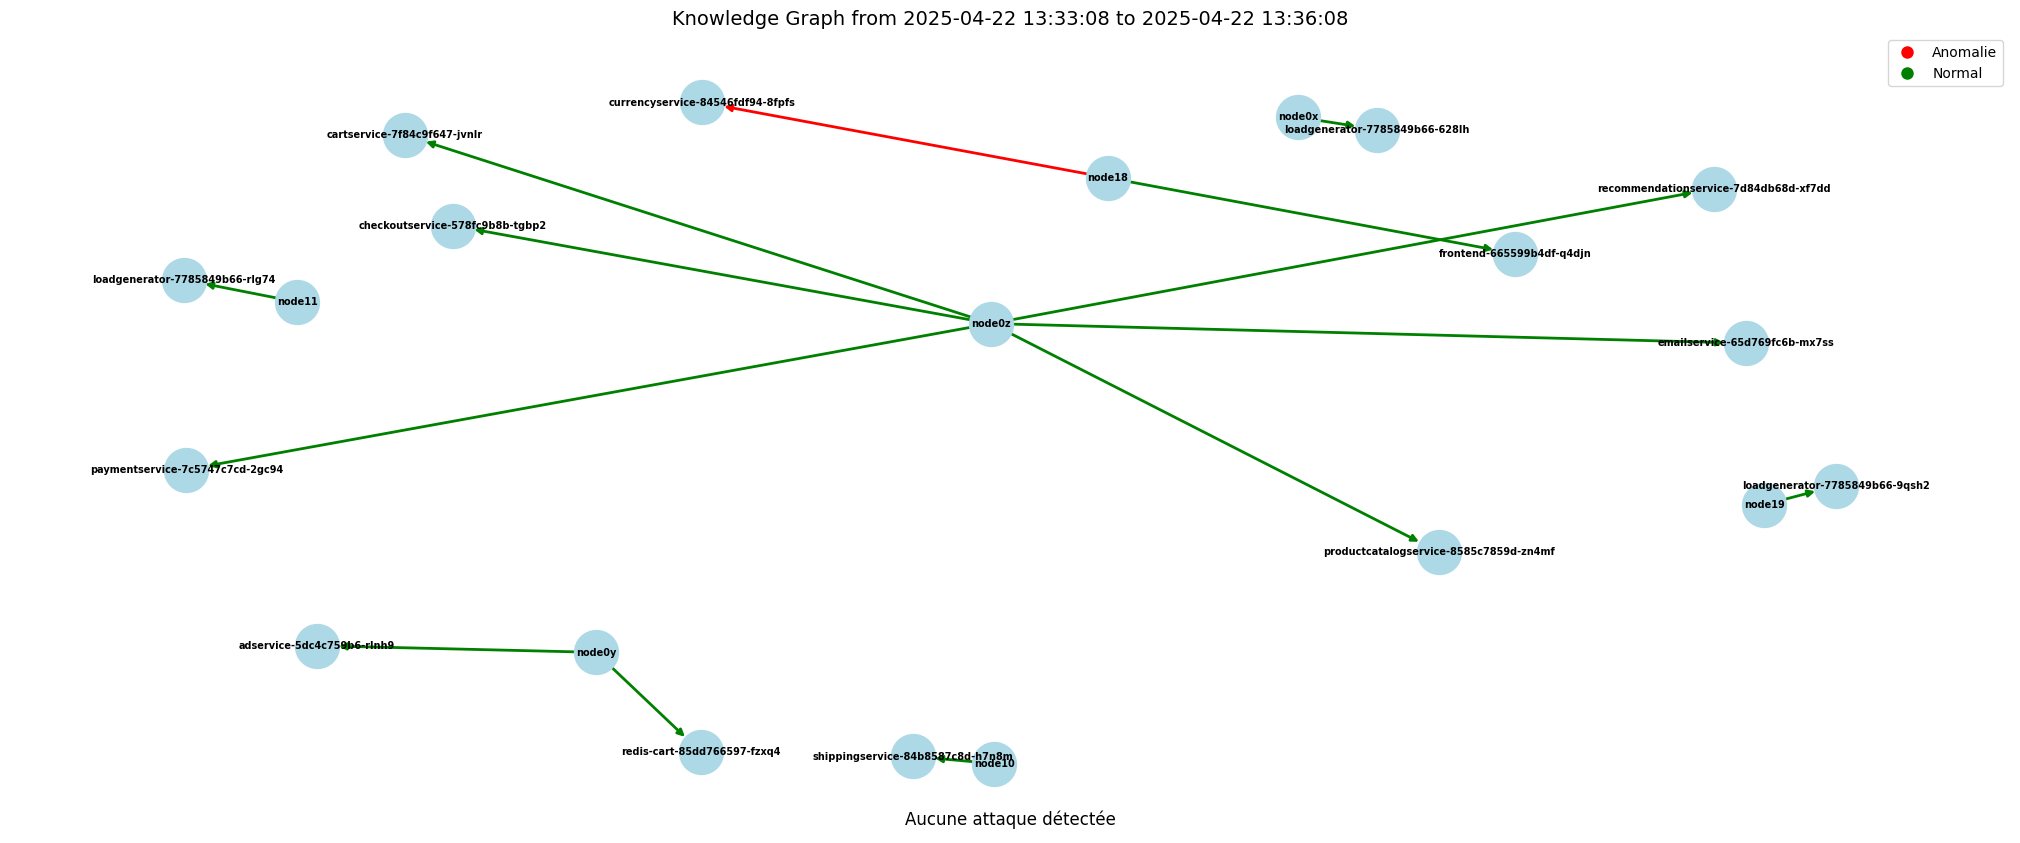

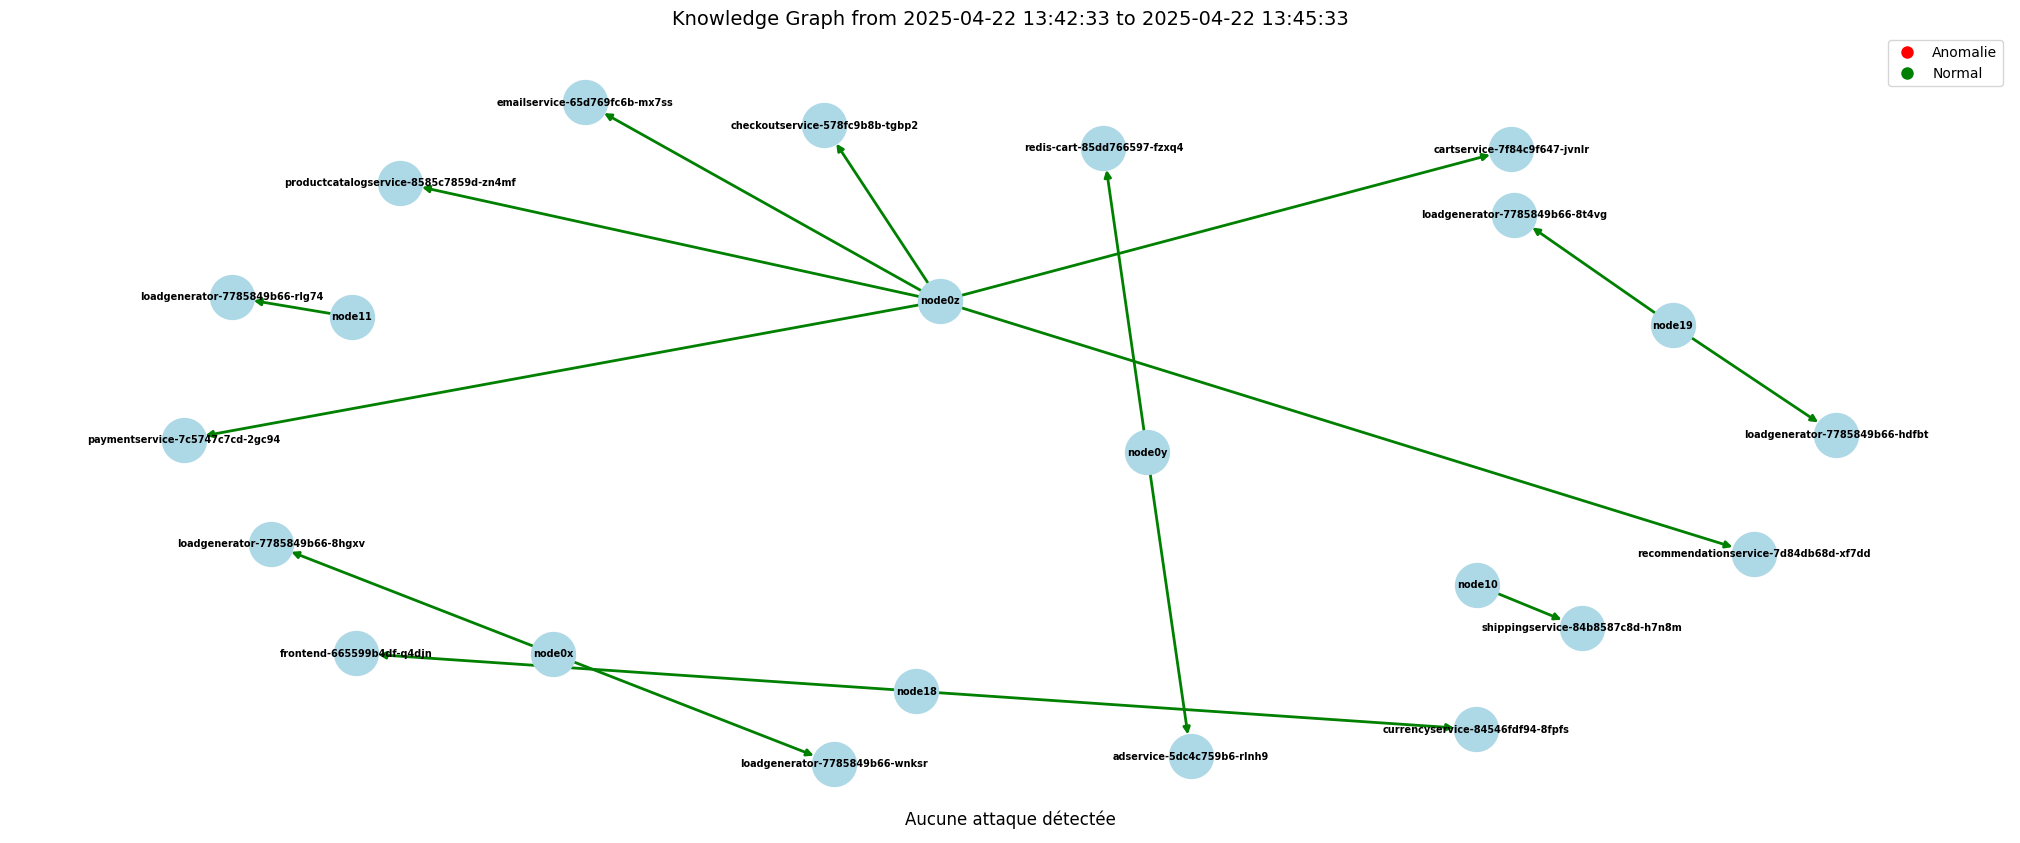

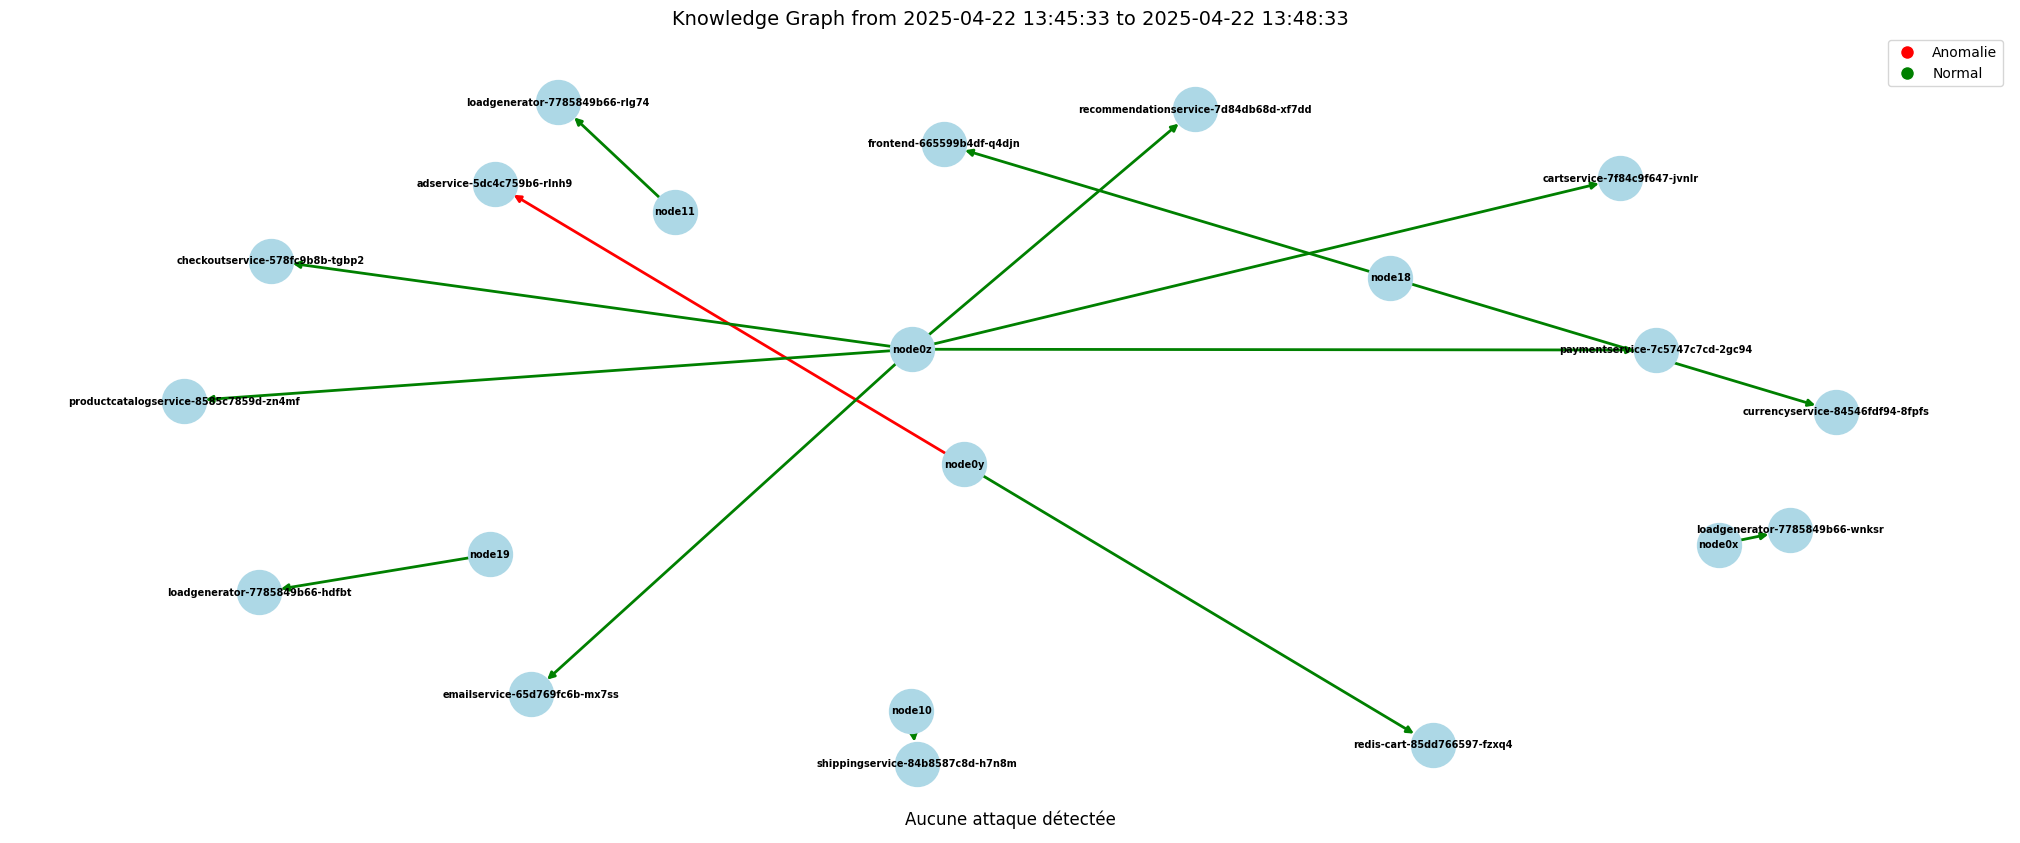

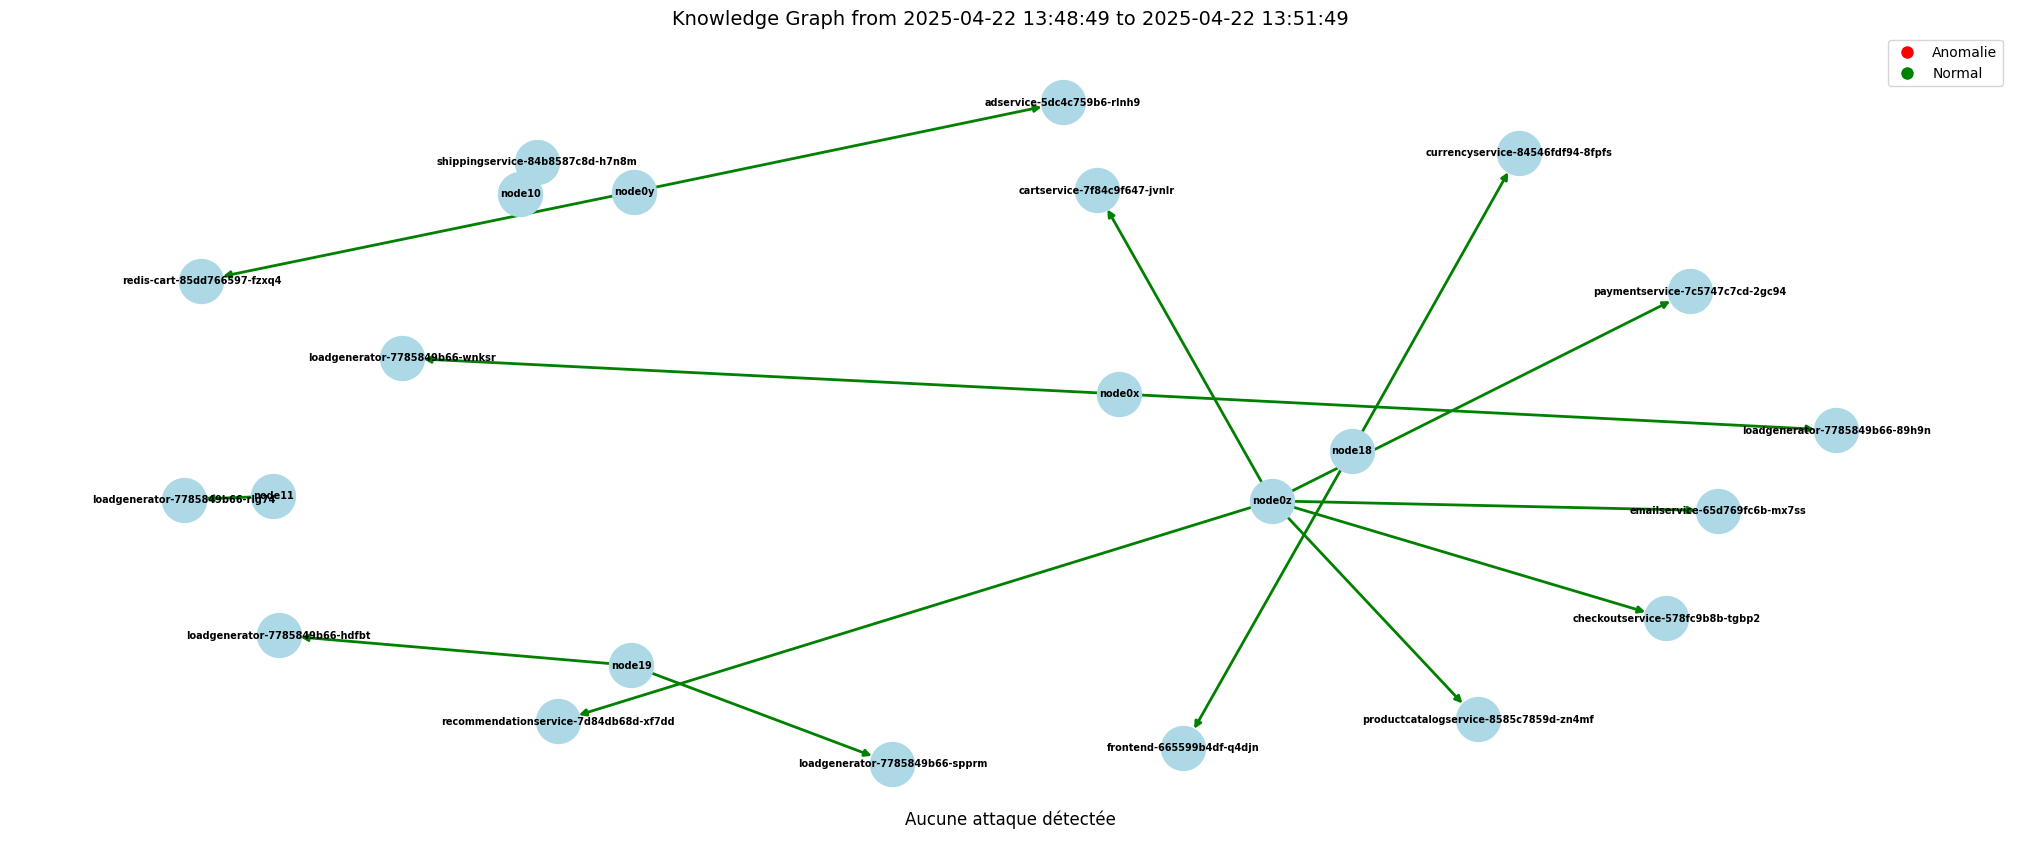

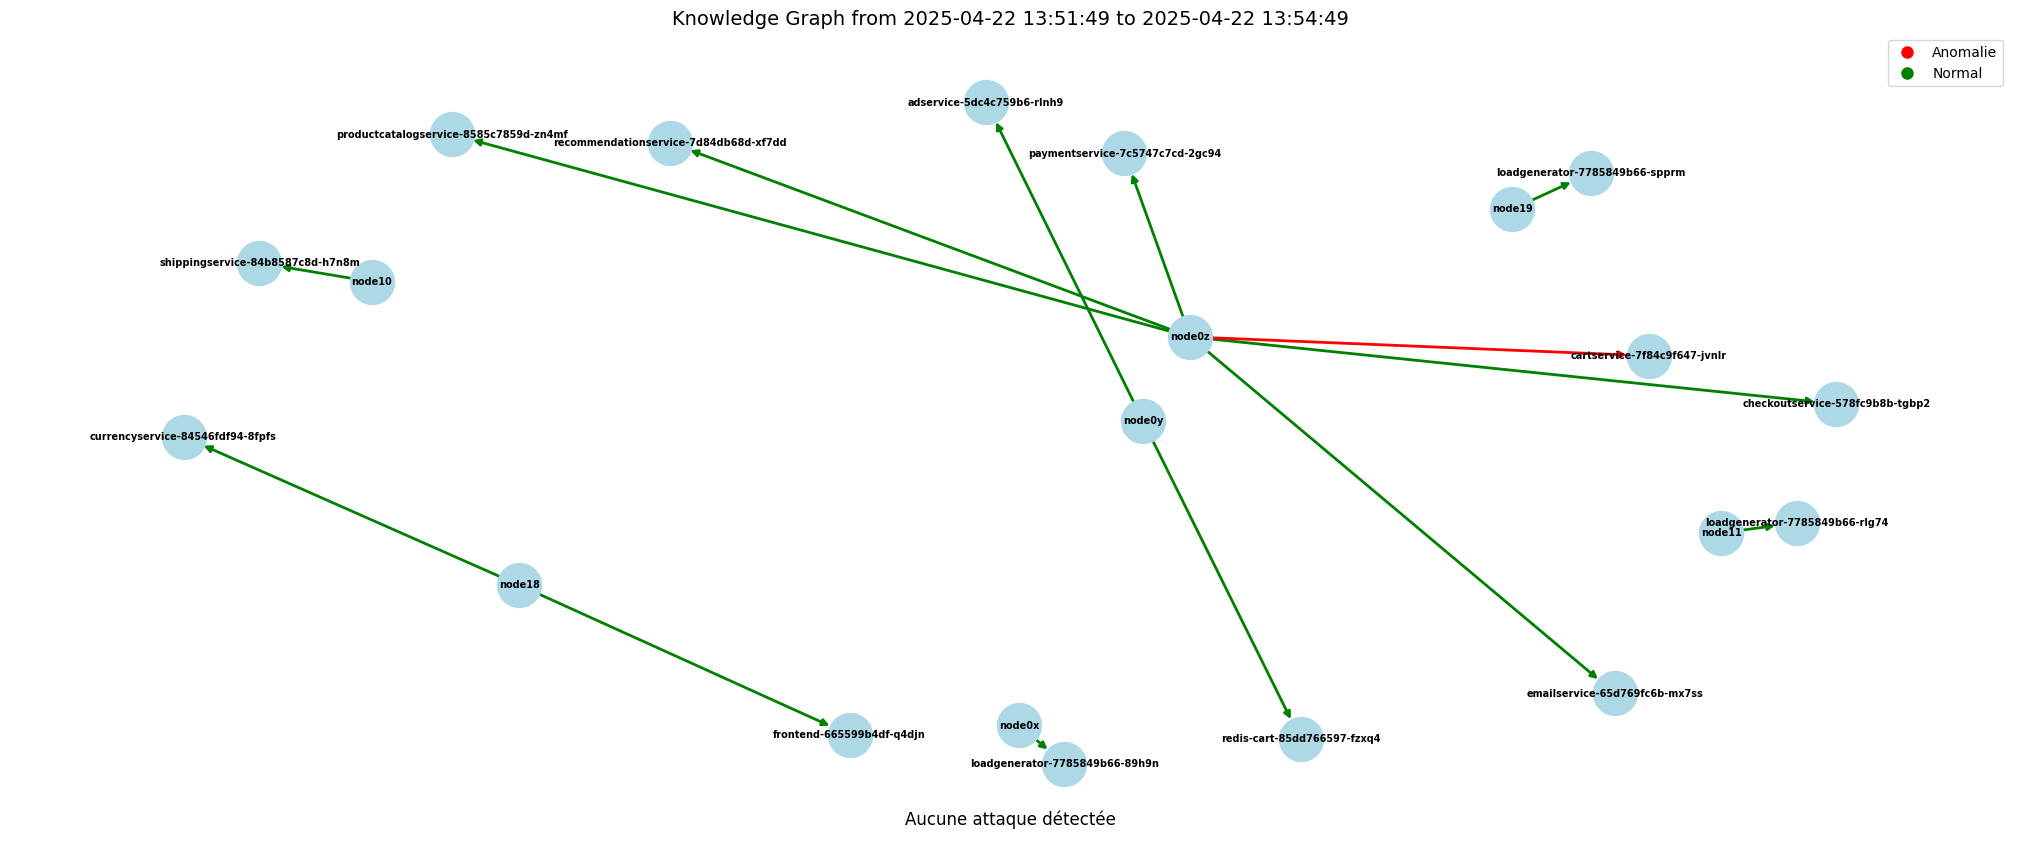

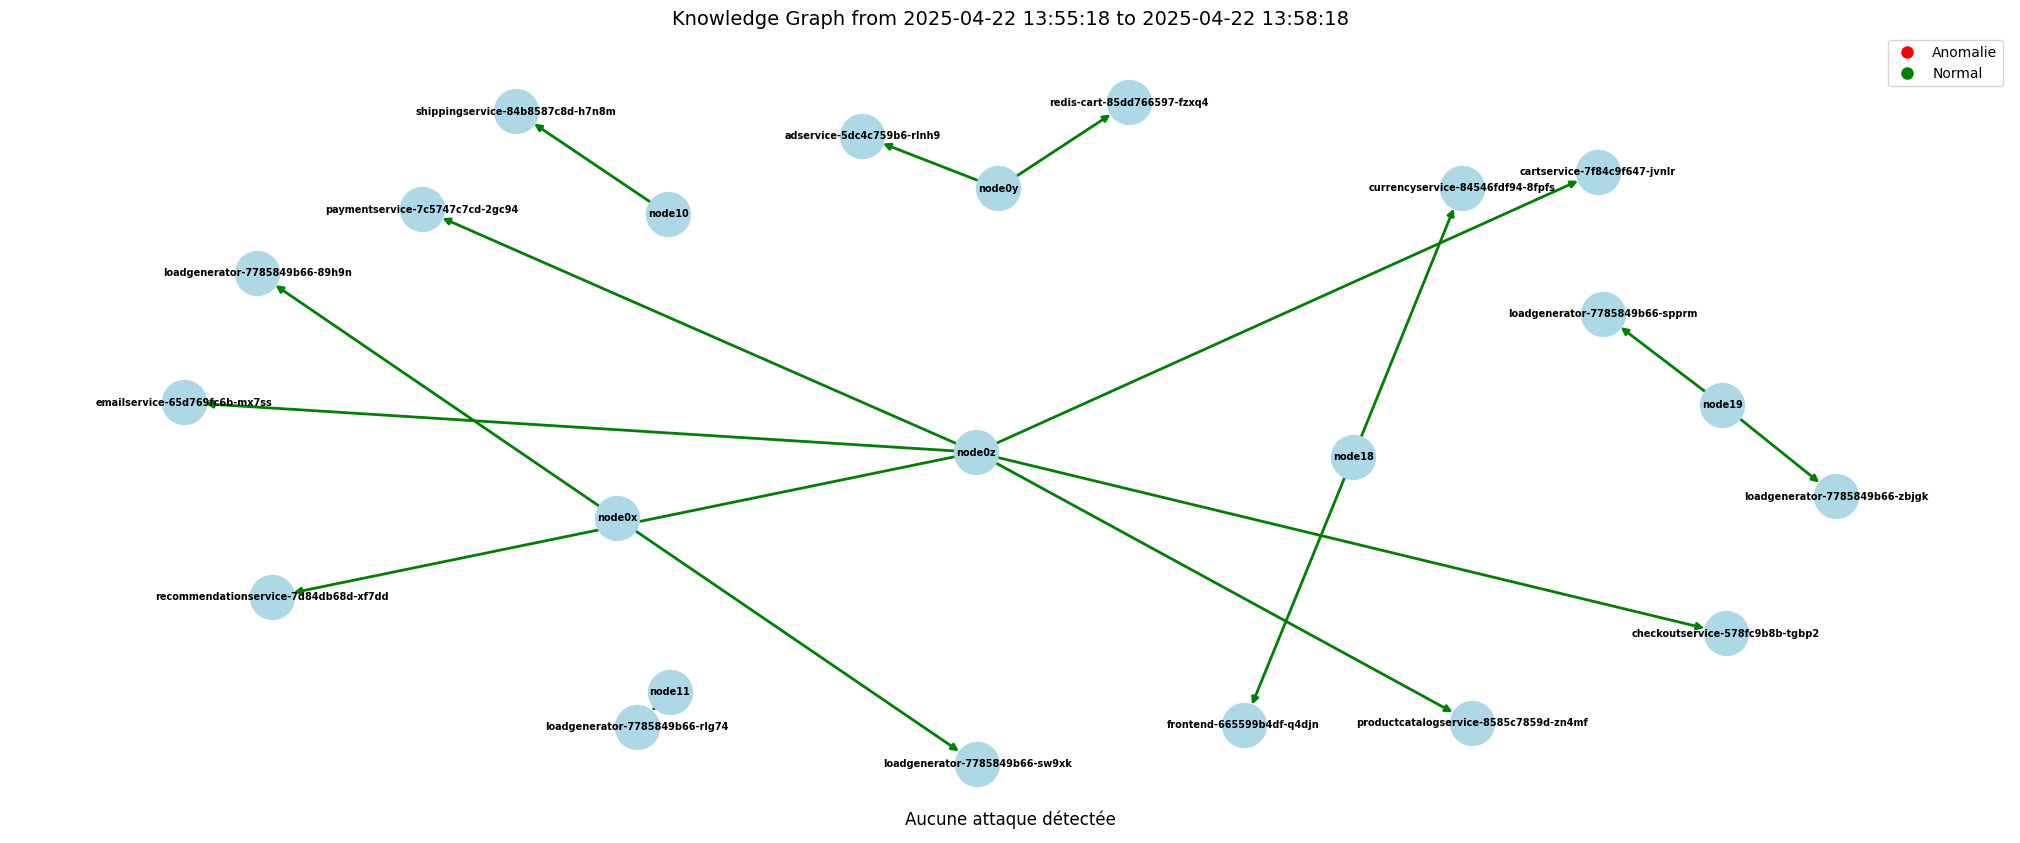

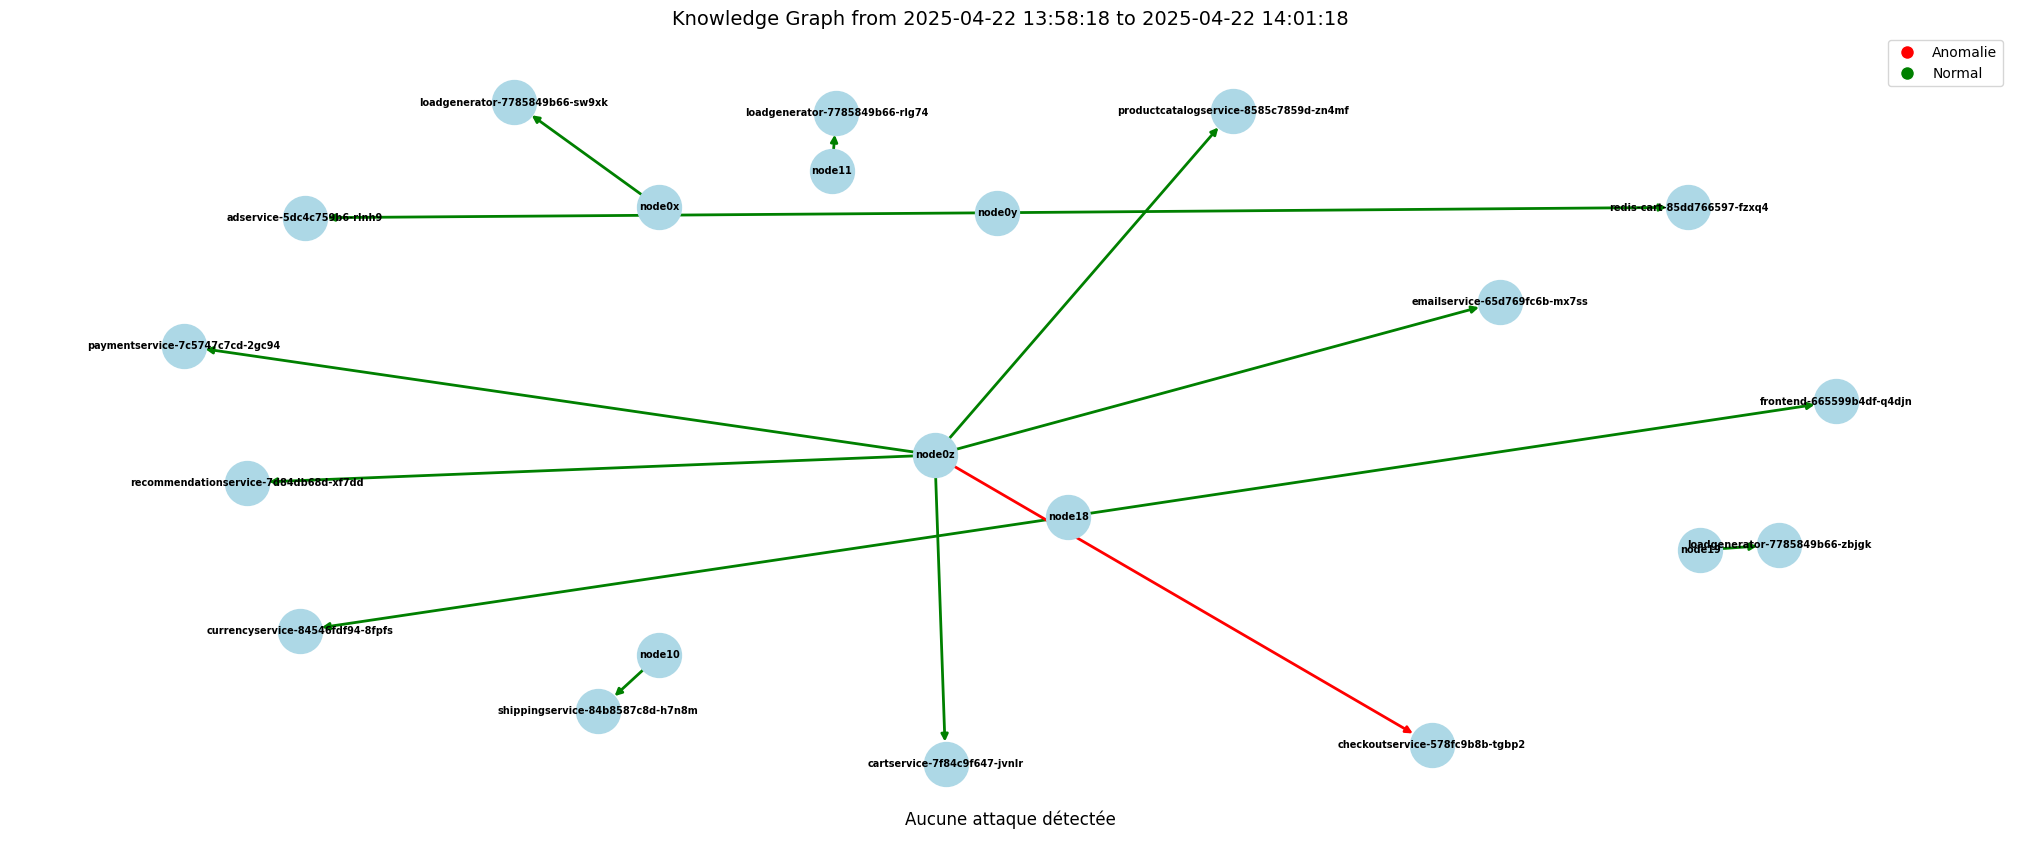

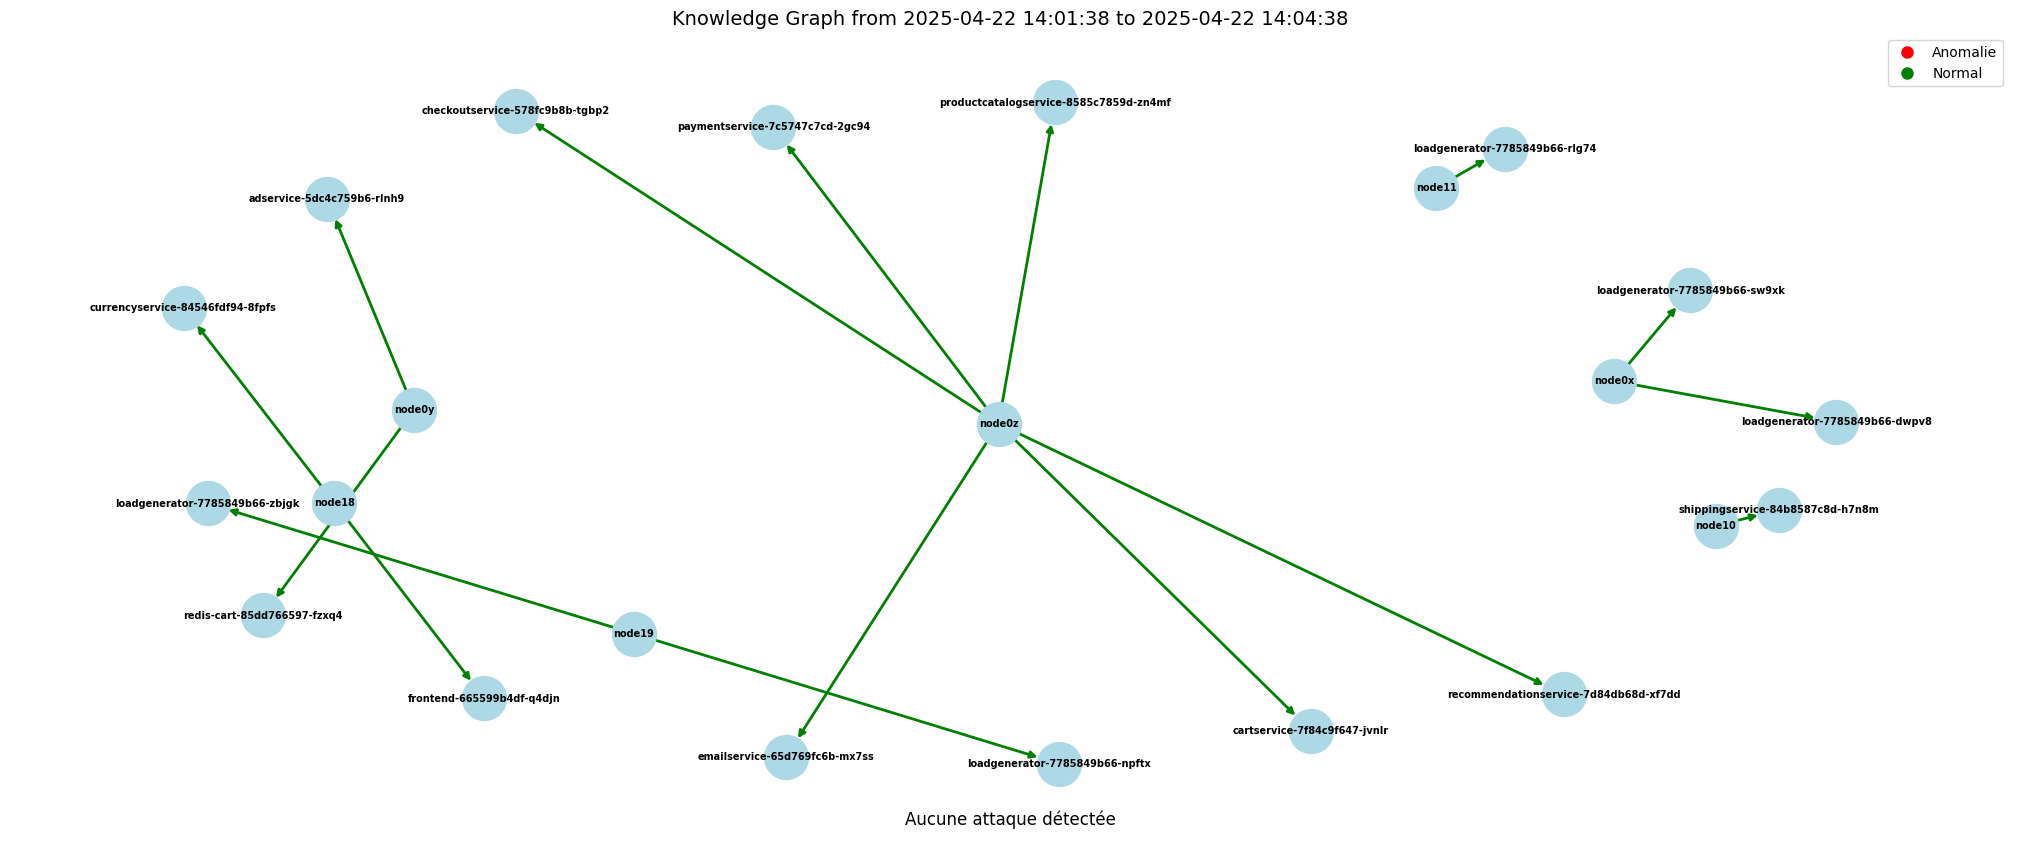

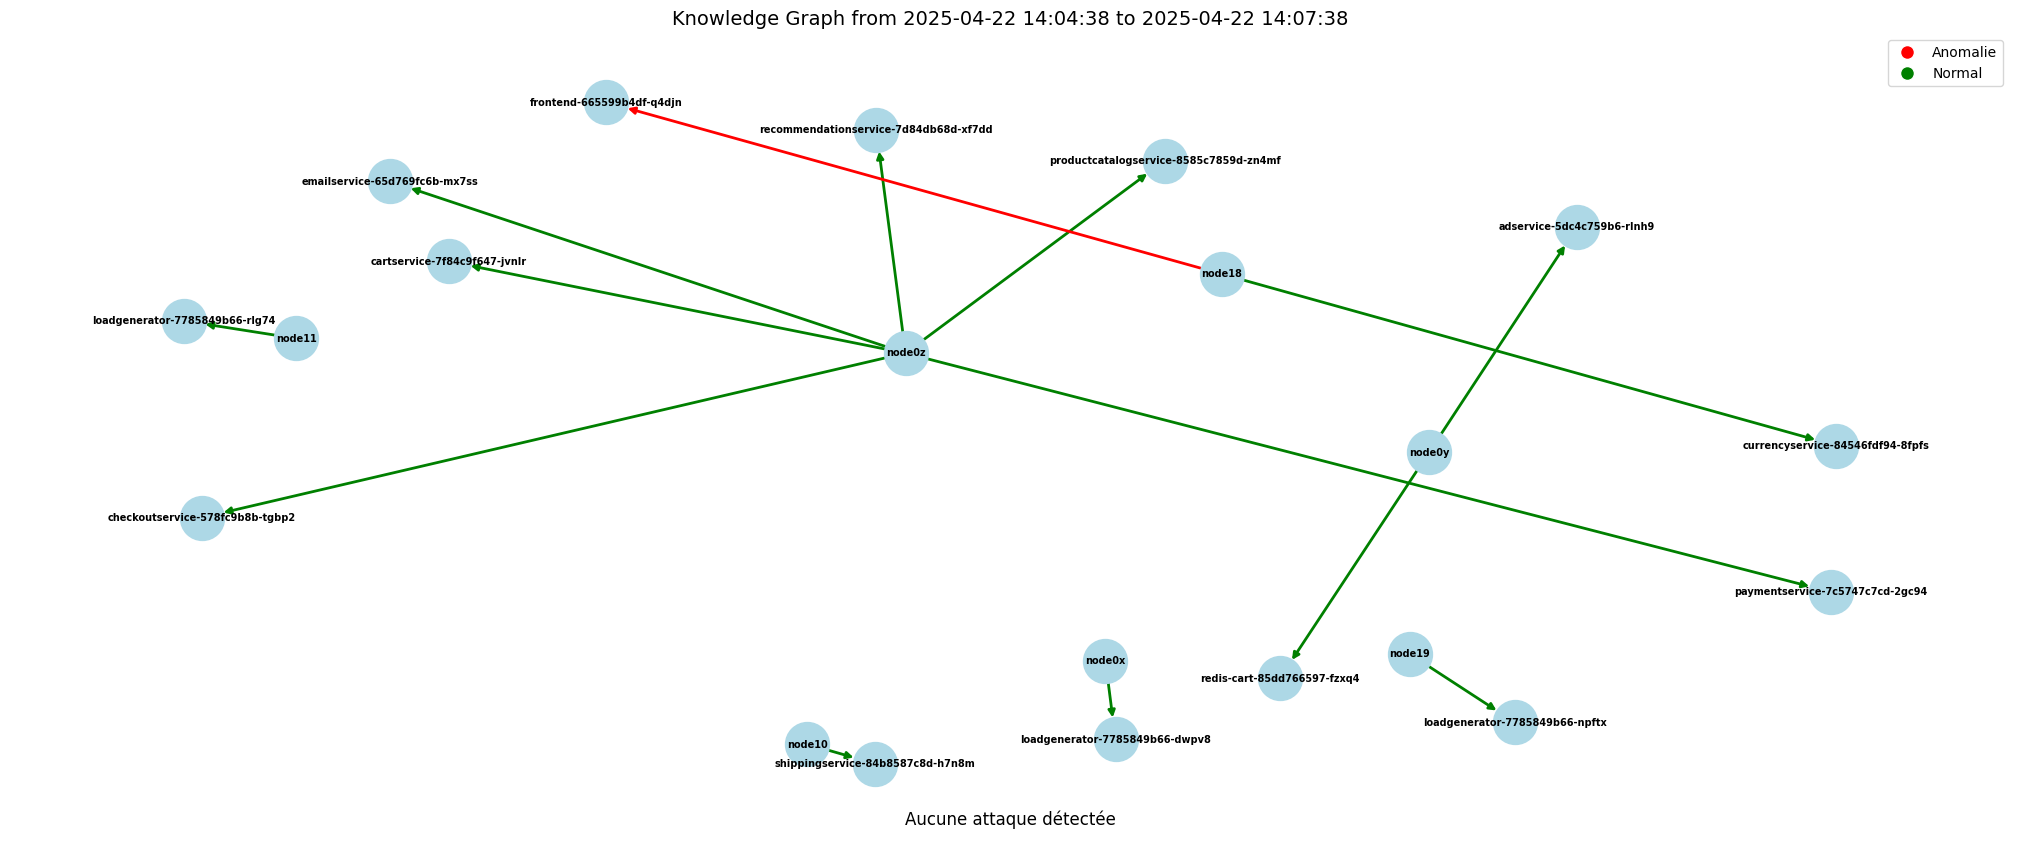

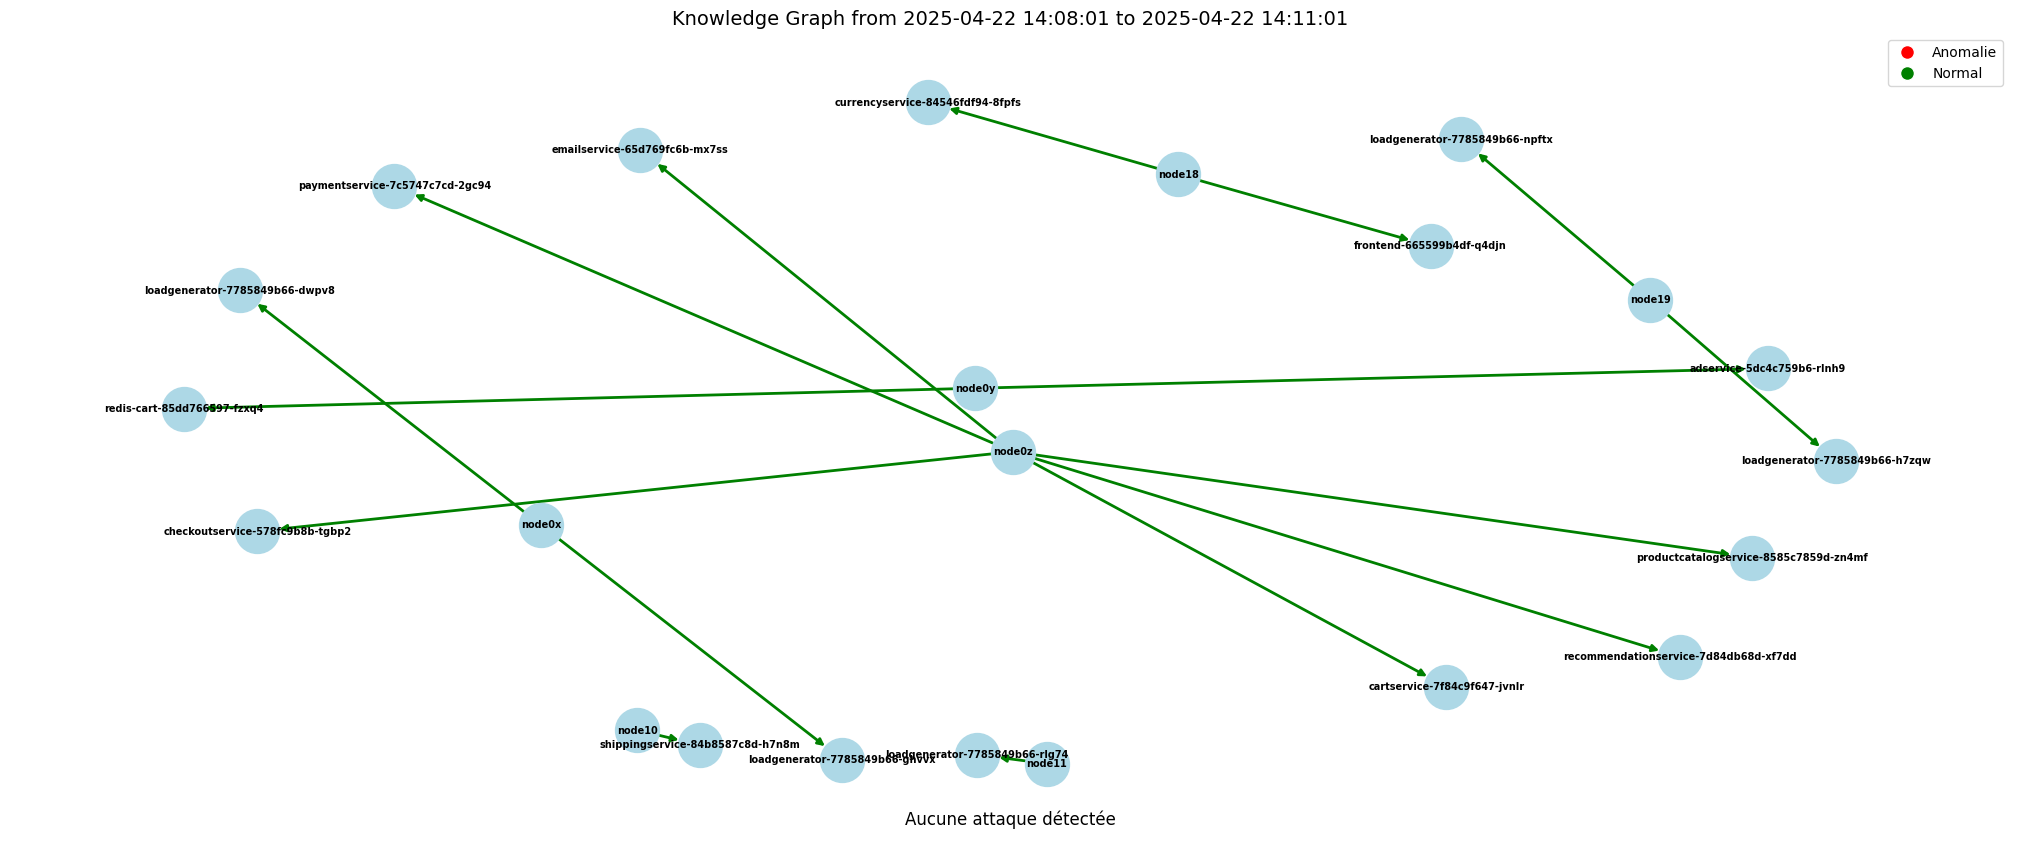

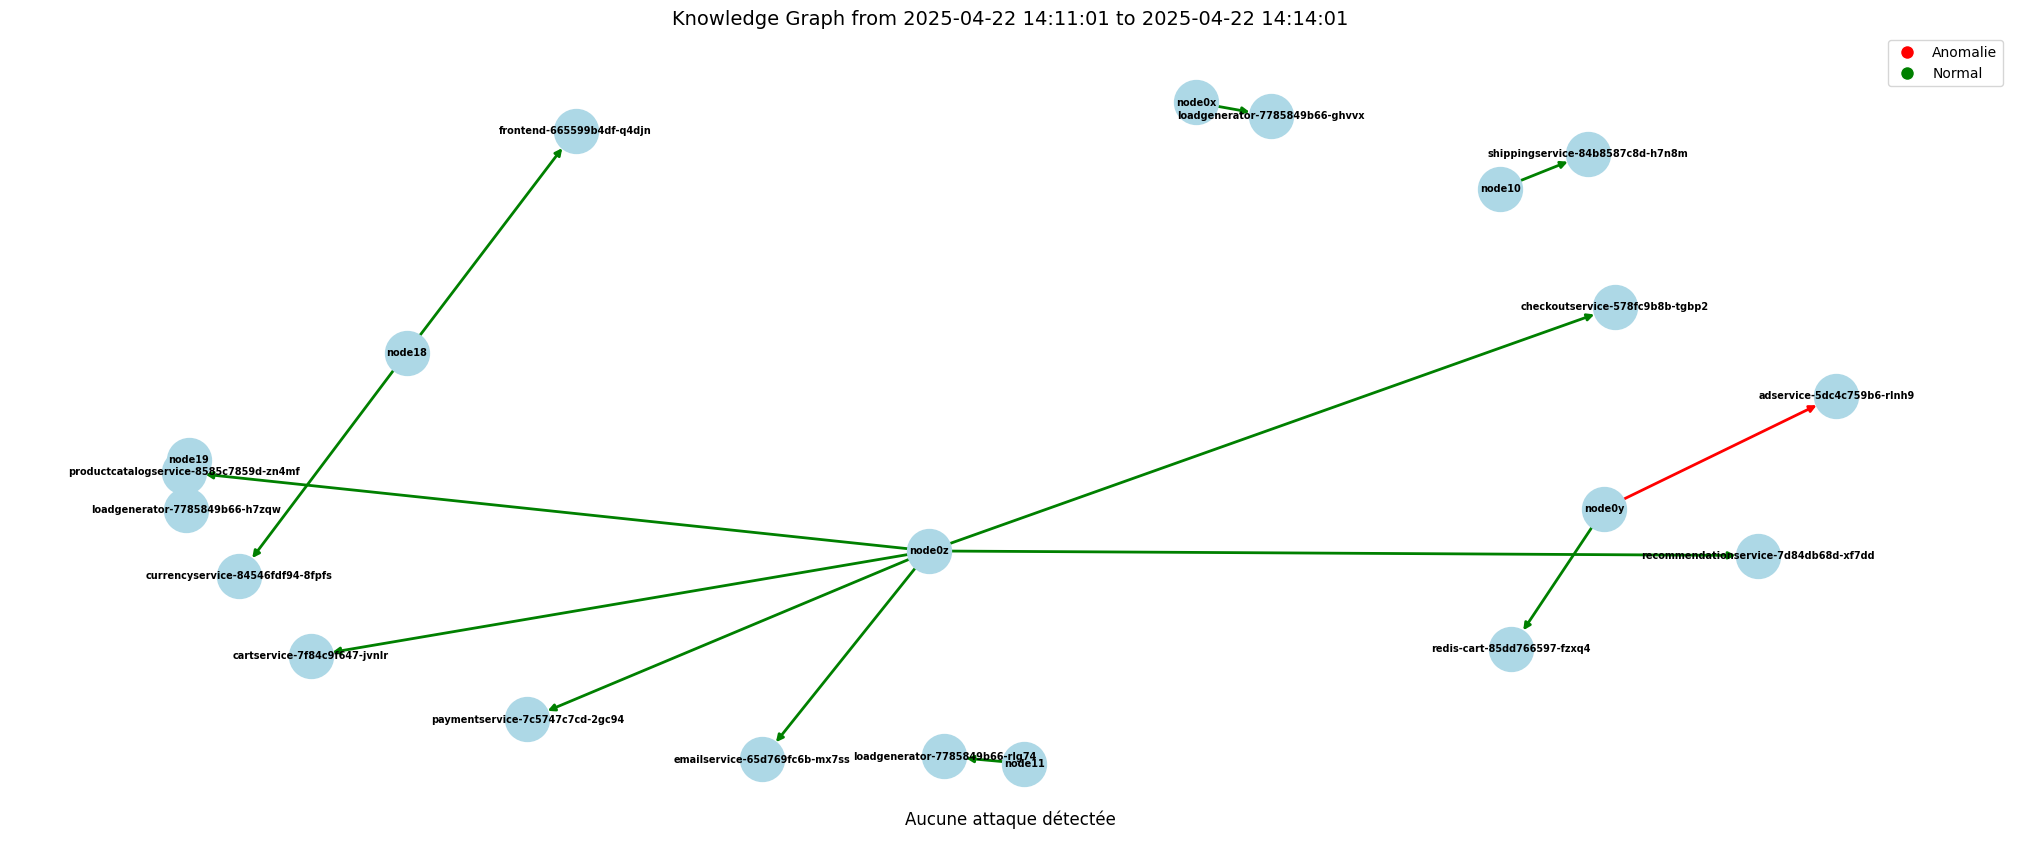

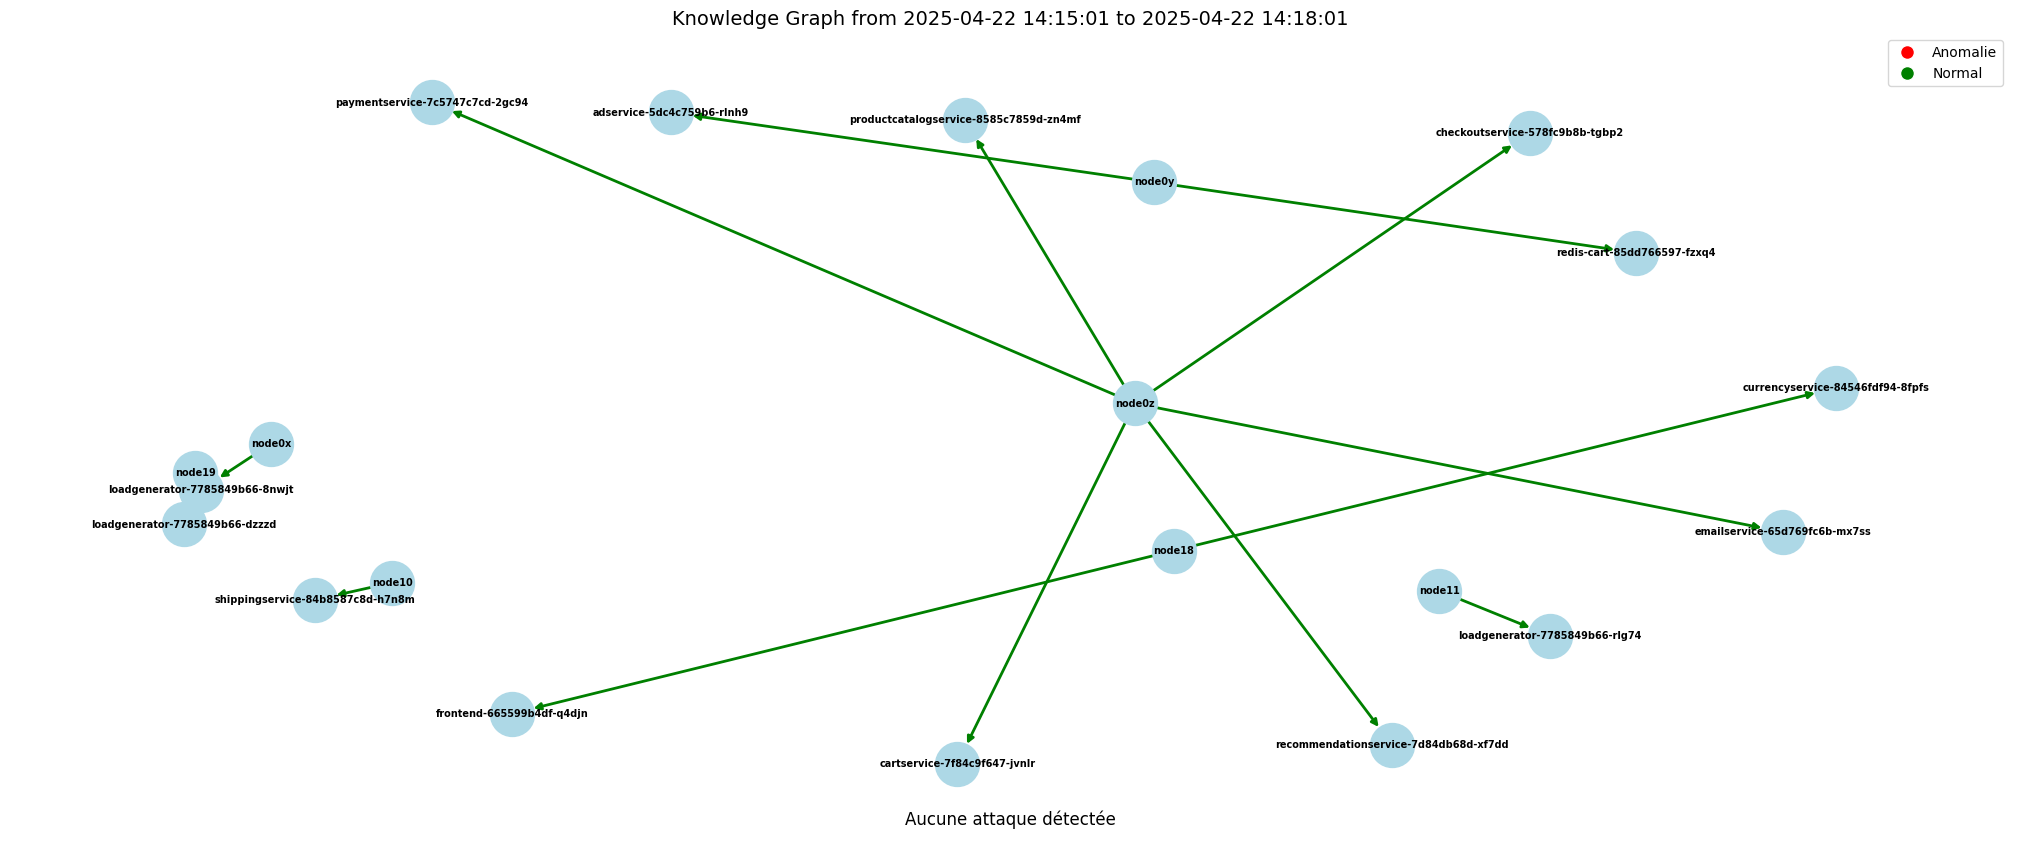

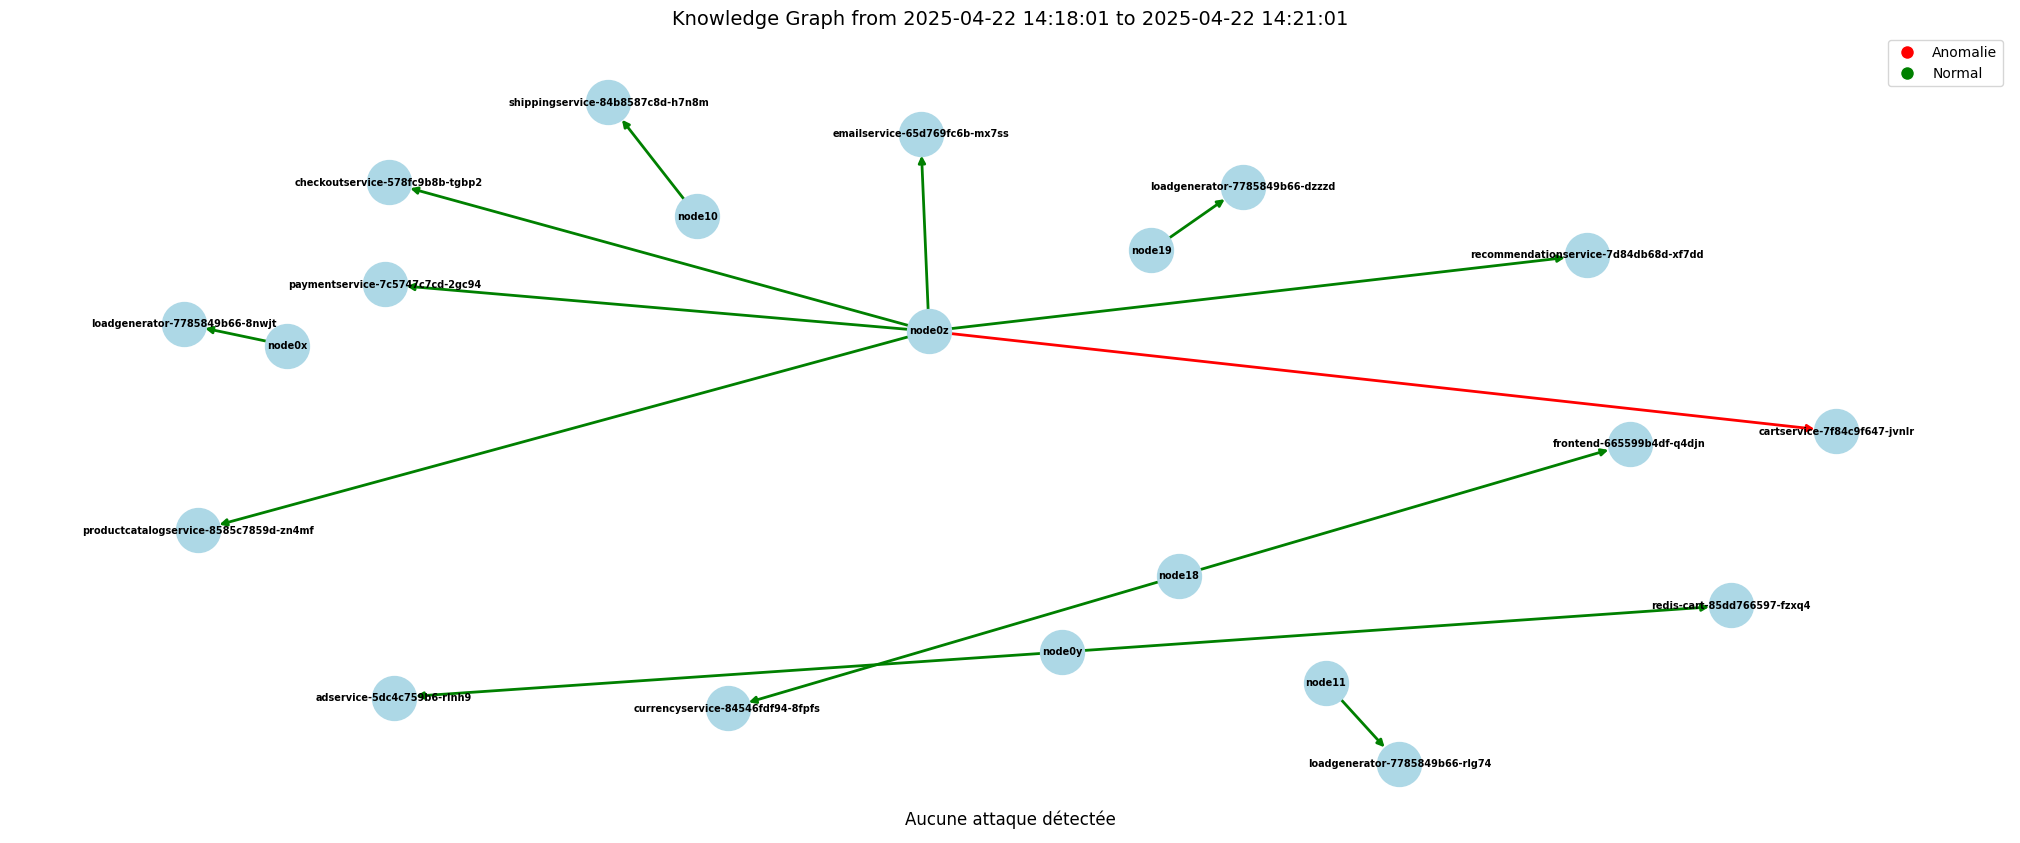

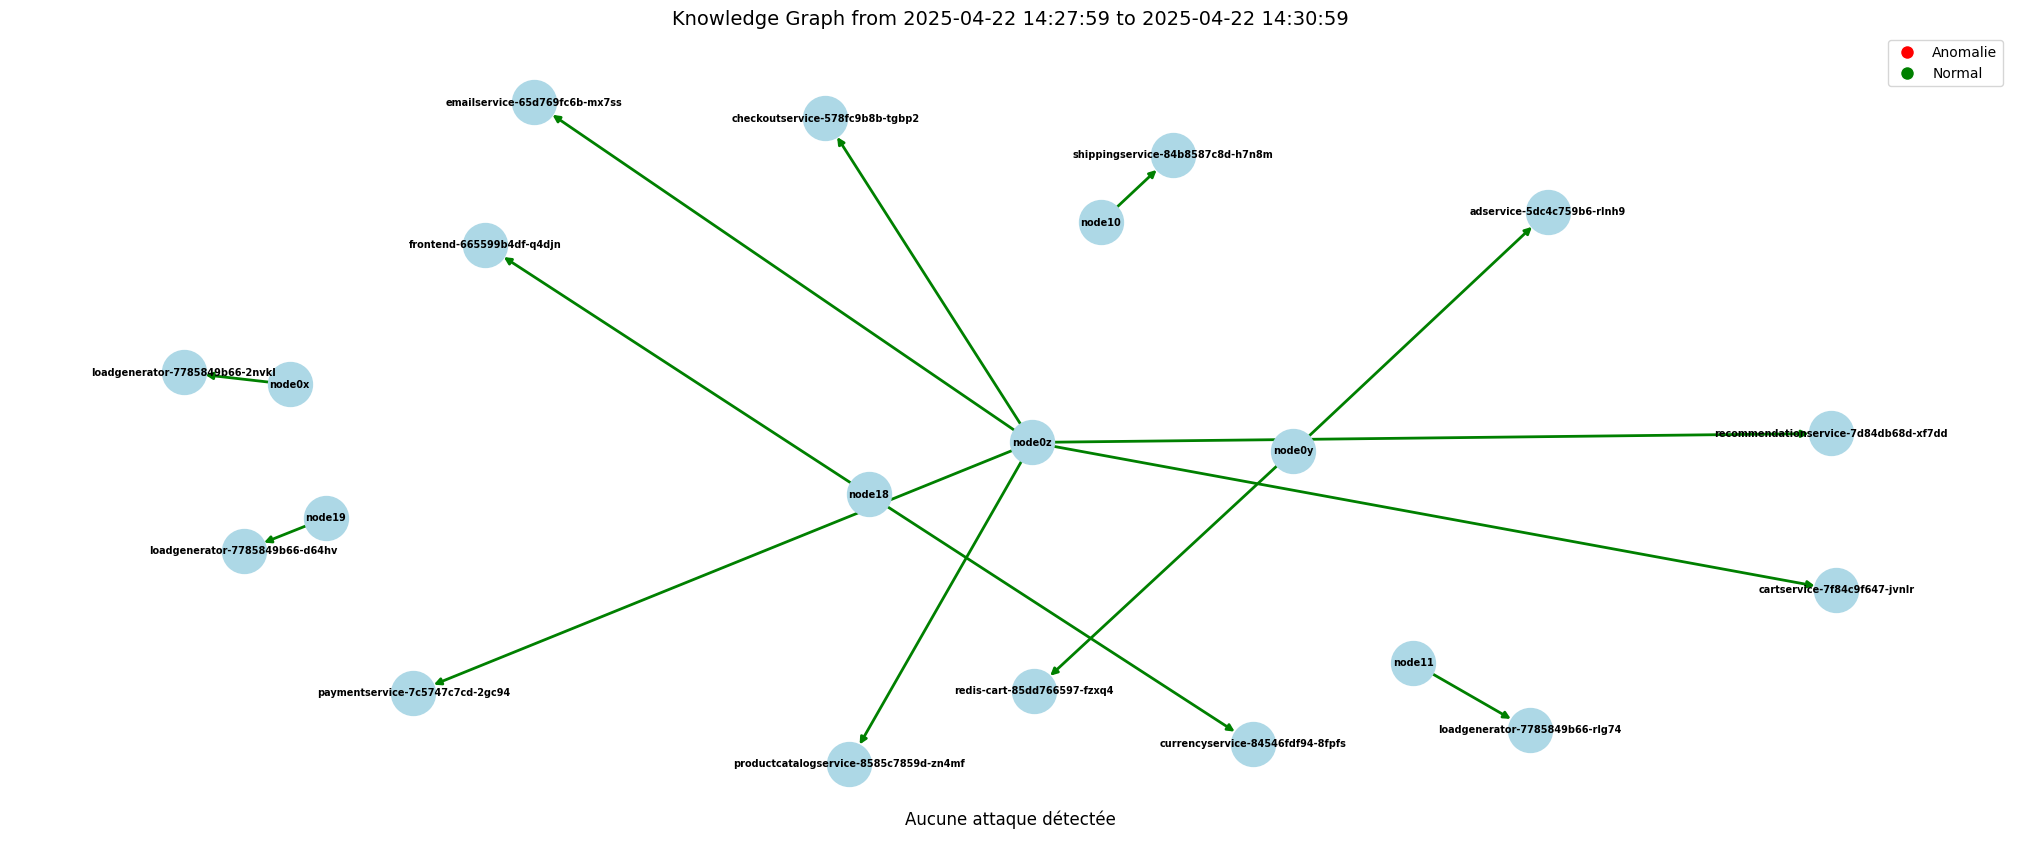

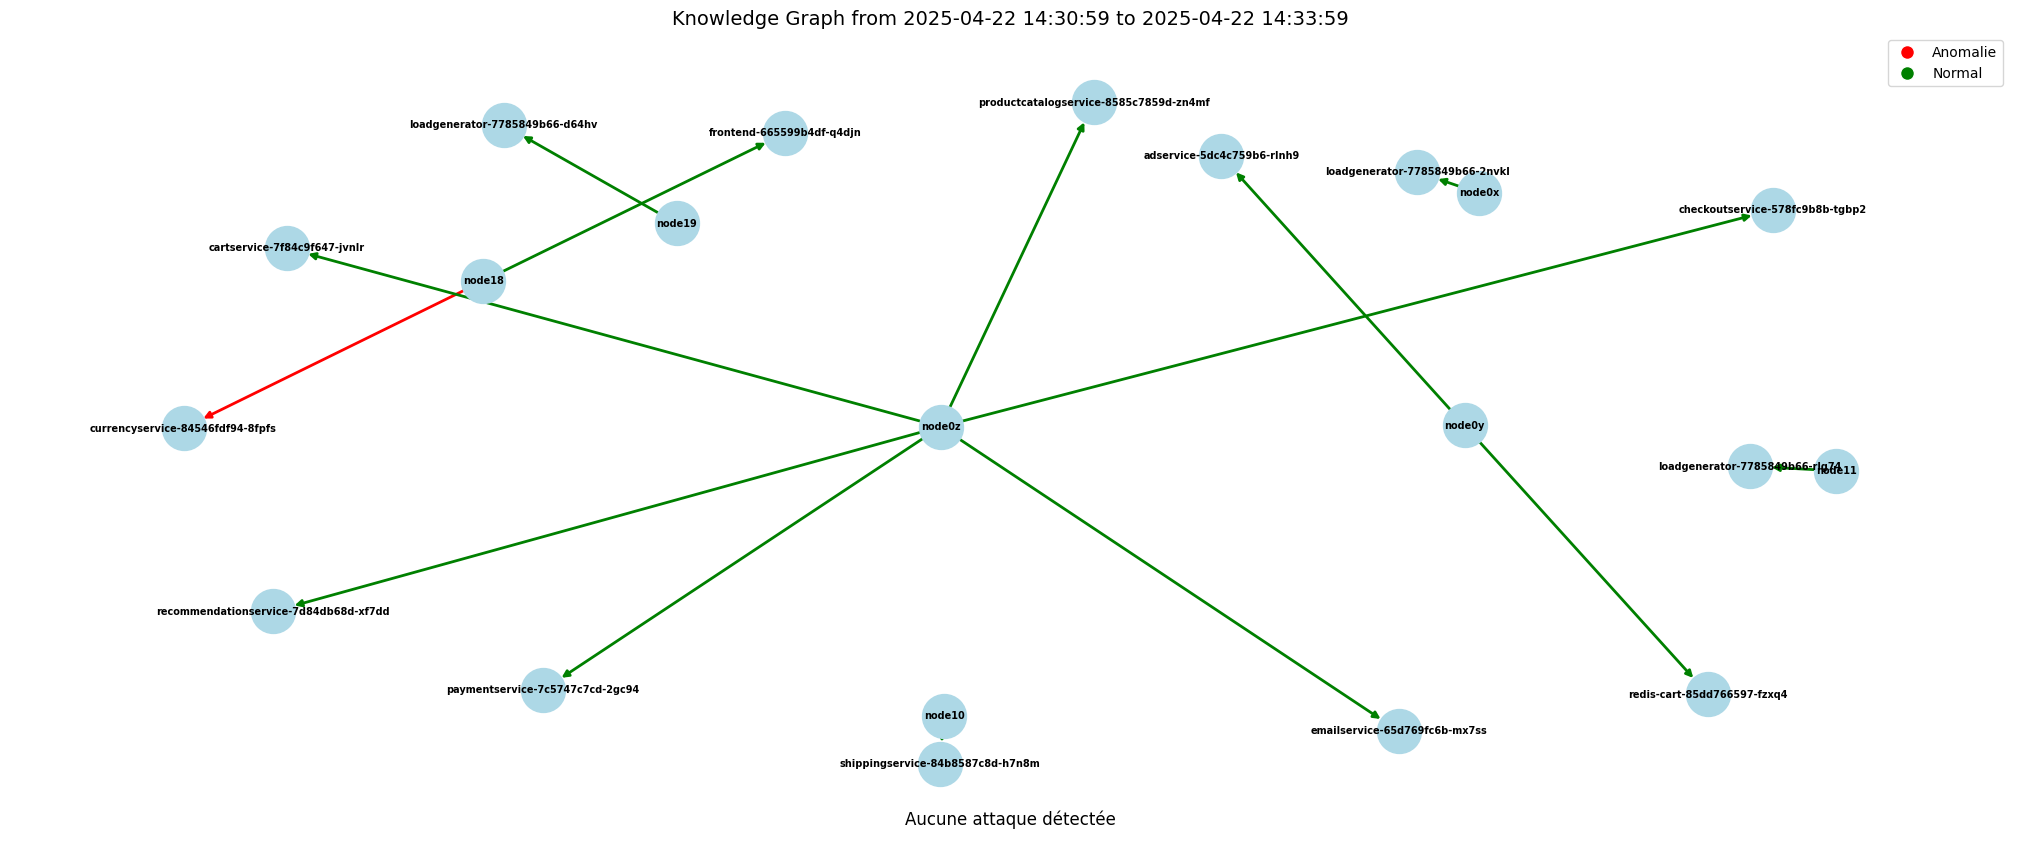

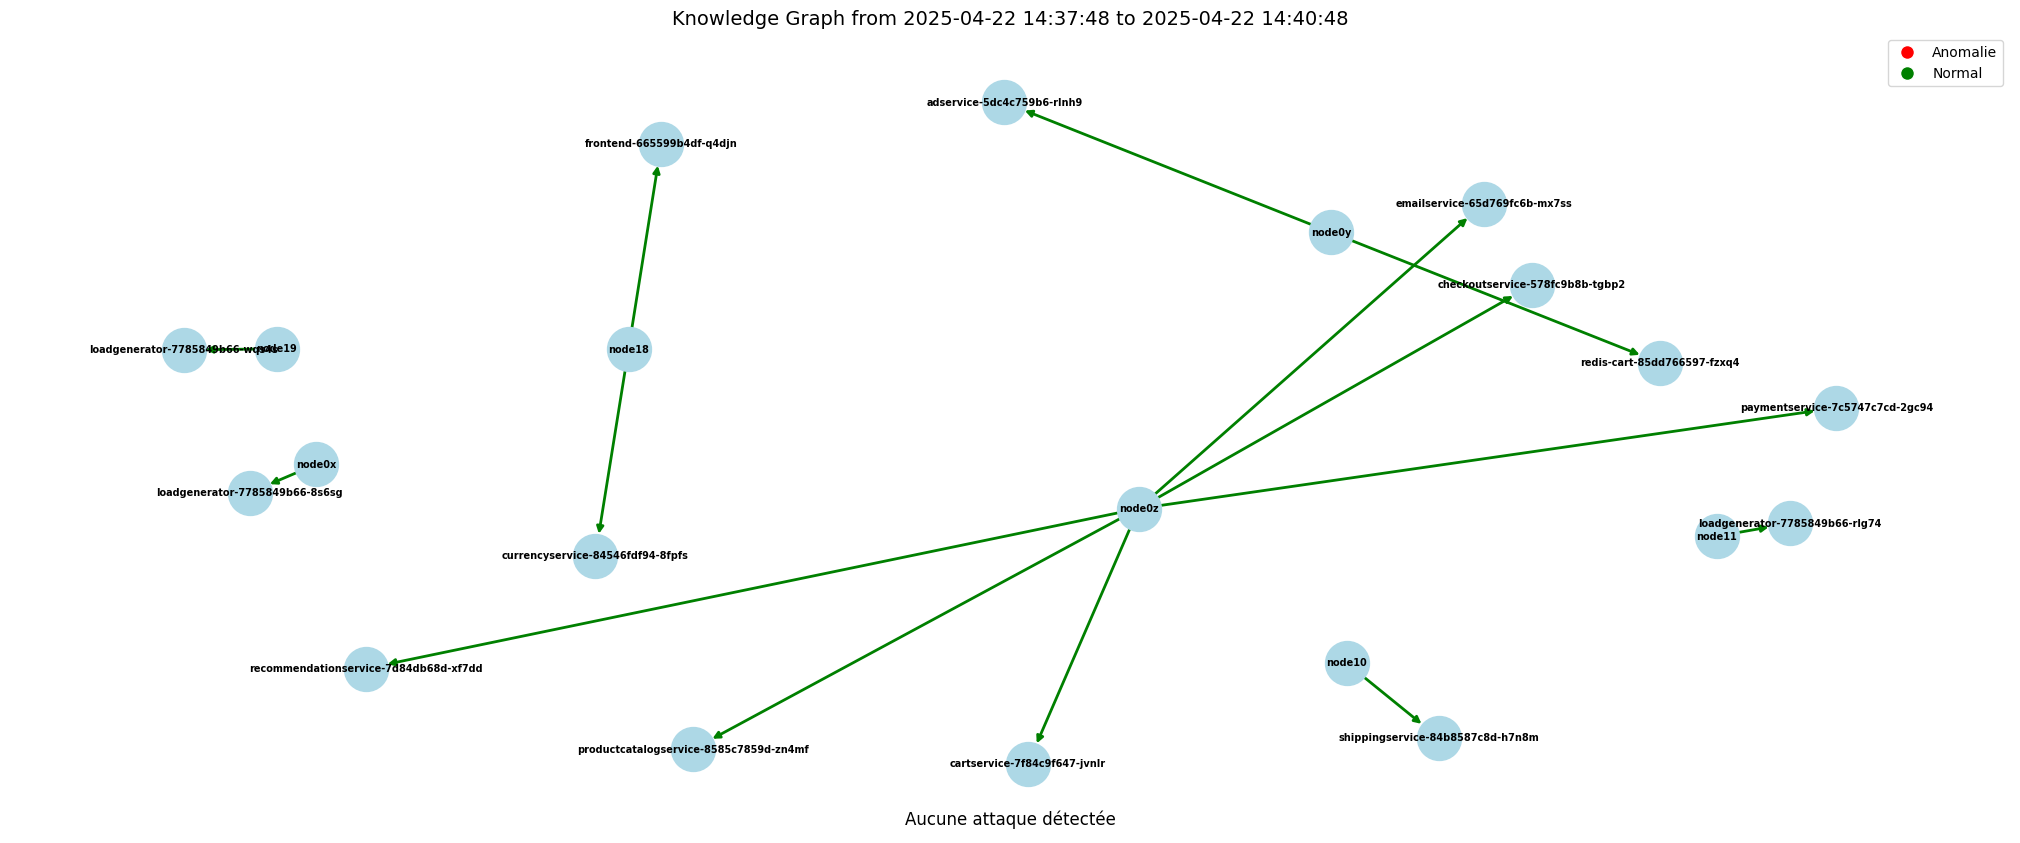

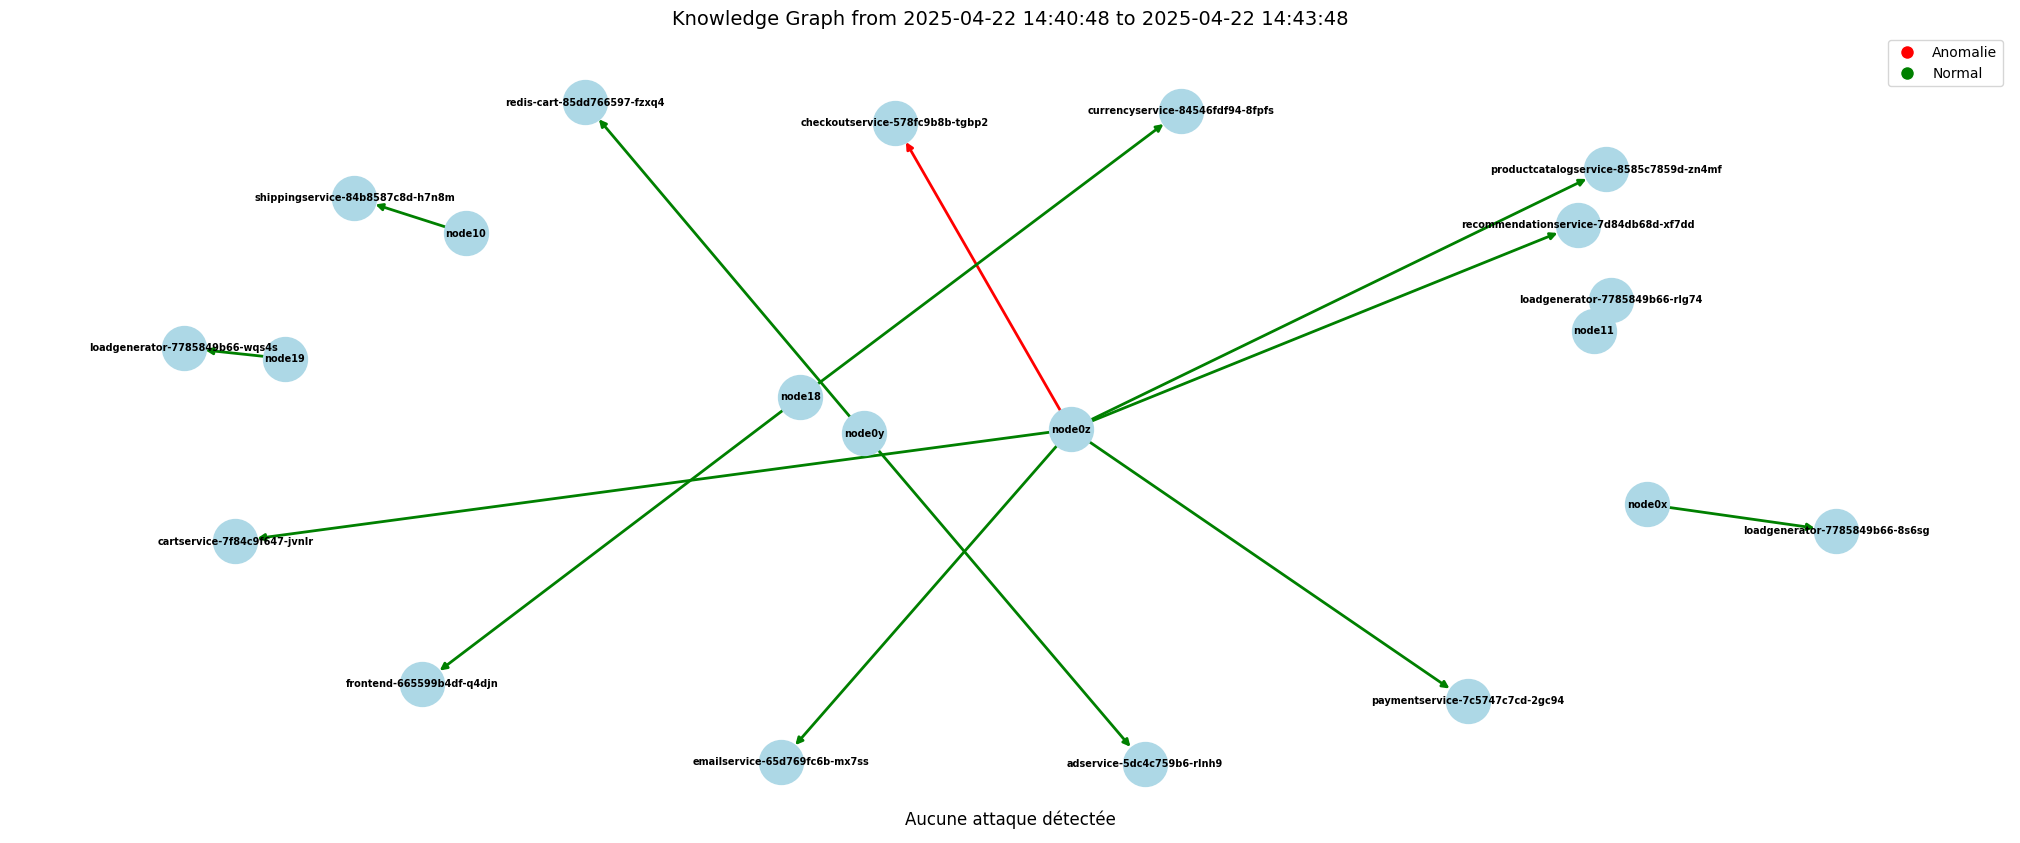

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta

# Charger le fichier CSV
df = pd.read_csv('final2_modified_sorted.csv')

# Convertir la colonne timestamp en format datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Fonction pour générer un graphe pour chaque intervalle de 3 minutes
def create_knowledge_graph(df, start_time, end_time):
    # Filtrer les données pour la période donnée (3 minutes)
    filtered_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]
    
    # Créer un graphe dirigé
    G = nx.DiGraph()

    # Initialiser les variables microservice_name et attack_type pour les retourner
    microservice_name = None
    attack_type = None

    # Parcourir chaque ligne filtrée pour ajouter les noeuds et les arêtes
    for index, row in filtered_df.iterrows():
        # Vérifier si la colonne 'Microservice' contient une valeur valide
        if pd.isna(row['Microservice']):
            continue  # Si le microservice est manquant, passer à la ligne suivante
        
        # Extraire le microservice attaqué et le type d'attaque
        microservice = row['Microservice']
        microservice_name, attack_type = microservice.split('_')  # Extrait le microservice et le type d'attaque

        # Ajouter les noeuds pour instance et pod
        instance = row['instance']
        pod = row['pod']
        G.add_node(instance, type='instance')
        G.add_node(pod, type='pod')

        # Vérifier la condition sur l'Abnormality class
        if row['Abnormality class'] == 'Normal':
            edge_color = 'green'
        else:
            edge_color = 'red'

        # Ajouter une arête entre instance et pod (arête générale) en vert
        G.add_edge(instance, pod, color='green', anomaly='Normal')

        # **Colorier l'arête en rouge uniquement si le microservice attaqué est présent dans le pod**
        if microservice_name in pod:  # Vérifie si le pod contient le microservice attaqué
            G.add_edge(instance, pod, color='red' if row['Abnormality class'] != 'Normal' else 'green', anomaly=row['Abnormality class'])

    return G, microservice_name, attack_type, row['Abnormality class']

# Fonction pour afficher le graphe et la description
def plot_graph(G, start_time, end_time, microservice_name, attack_type, anomaly_class):
    plt.figure(figsize=(20, 8))
    
    # Extraire les couleurs des arêtes
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    
    # Dessiner le graphe
    pos = nx.spring_layout(G, seed=84)
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=7, edge_color=edge_colors, width=2, font_weight='bold')
    
    # Afficher le titre
    plt.title(f"Knowledge Graph from {start_time} to {end_time}", fontsize=14)
    
    # Afficher la légende pour les anomalies
    red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Anomalie', markerfacecolor='red', markersize=10)
    green_patch = plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='green', markersize=10)
    plt.legend(handles=[red_patch, green_patch])
    
    # Afficher la description sous le graphe selon l'Abnormality class
    if anomaly_class != 'Normal':
        plt.figtext(0.5, 0.01, f"Microservice attaqué: {microservice_name}, Type d'attaque: {attack_type.upper()}", wrap=True, horizontalalignment='center', fontsize=12)
    else:
        plt.figtext(0.5, 0.01, "Aucune attaque détectée", wrap=True, horizontalalignment='center', fontsize=12)
    
    plt.show()

# Identifier les lignes où la valeur de `Microservice` change (nouvelle expérience)
df['microservice_change'] = df['Microservice'].ne(df['Microservice'].shift()).cumsum()

# Parcourir chaque expérience (groupe de lignes avec le même microservice)
for exp_id, exp_df in df.groupby('microservice_change'):
    # Le premier timestamp de l'expérience
    start_time = exp_df['timestamp'].min()
    end_time = start_time + timedelta(minutes=6)
    
    # Diviser l'expérience en 2 phases de 3 minutes : avant et après l'injection
    # 3 premières minutes (avant l'injection)
    G1, microservice_name, attack_type, anomaly_class = create_knowledge_graph(exp_df, start_time, start_time + timedelta(minutes=3))
    plot_graph(G1, start_time, start_time + timedelta(minutes=3), microservice_name, attack_type, anomaly_class)
    
    # 3 dernières minutes (après l'injection)
    G2, _, _, _ = create_knowledge_graph(exp_df, start_time + timedelta(minutes=3), end_time)
    plot_graph(G2, start_time + timedelta(minutes=3), end_time, microservice_name, attack_type, anomaly_class)
